In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

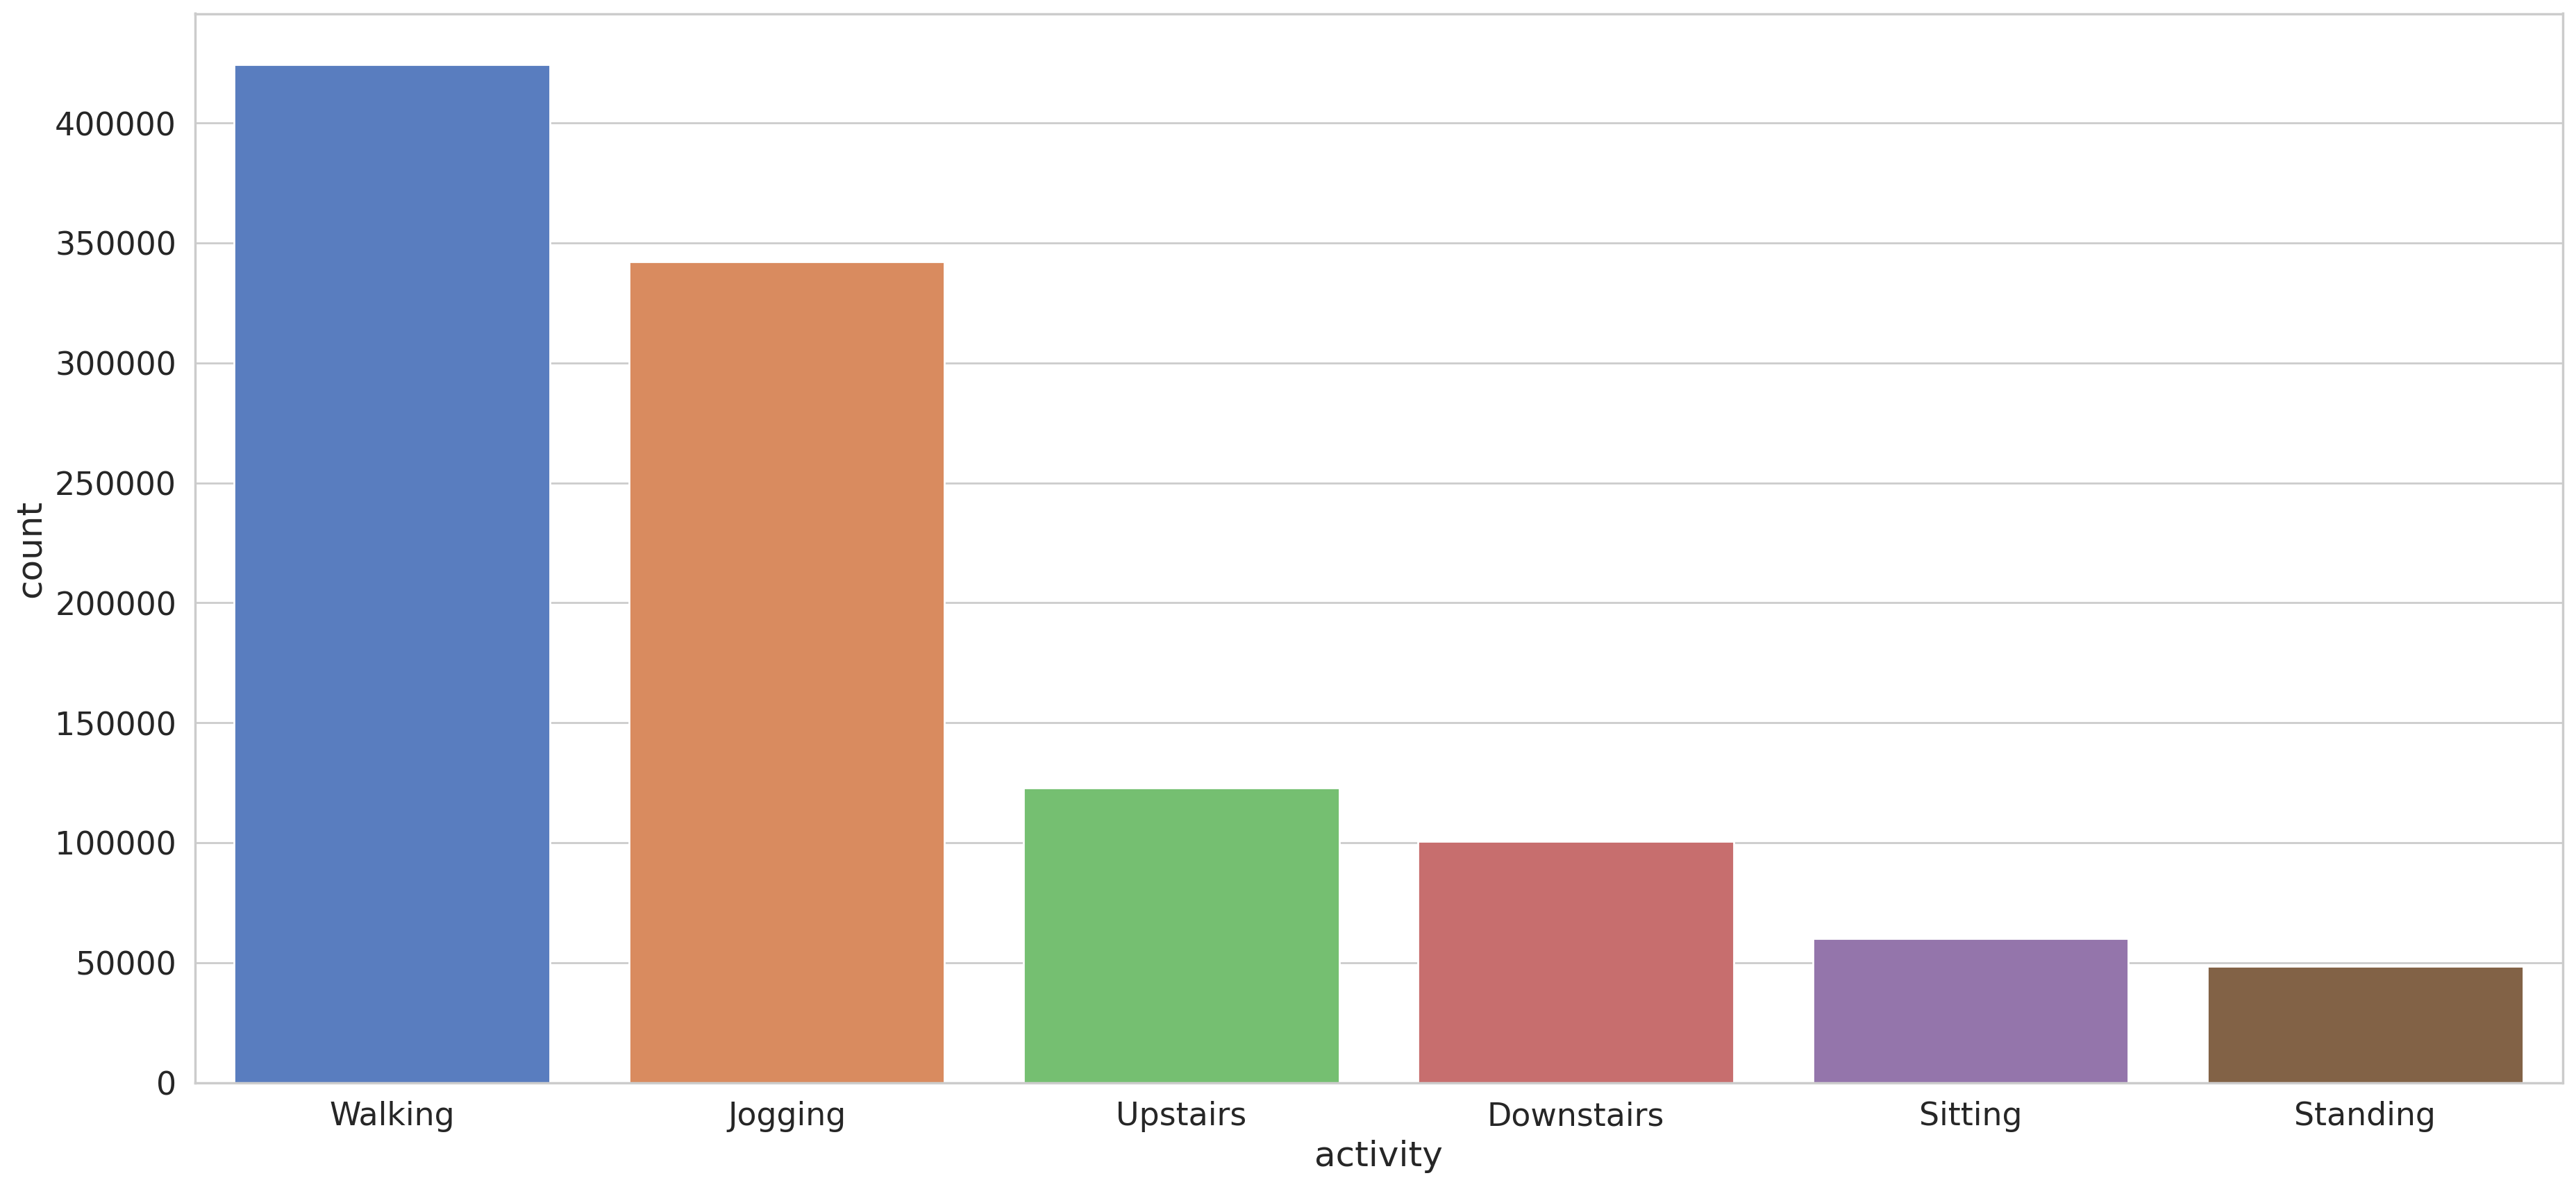

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

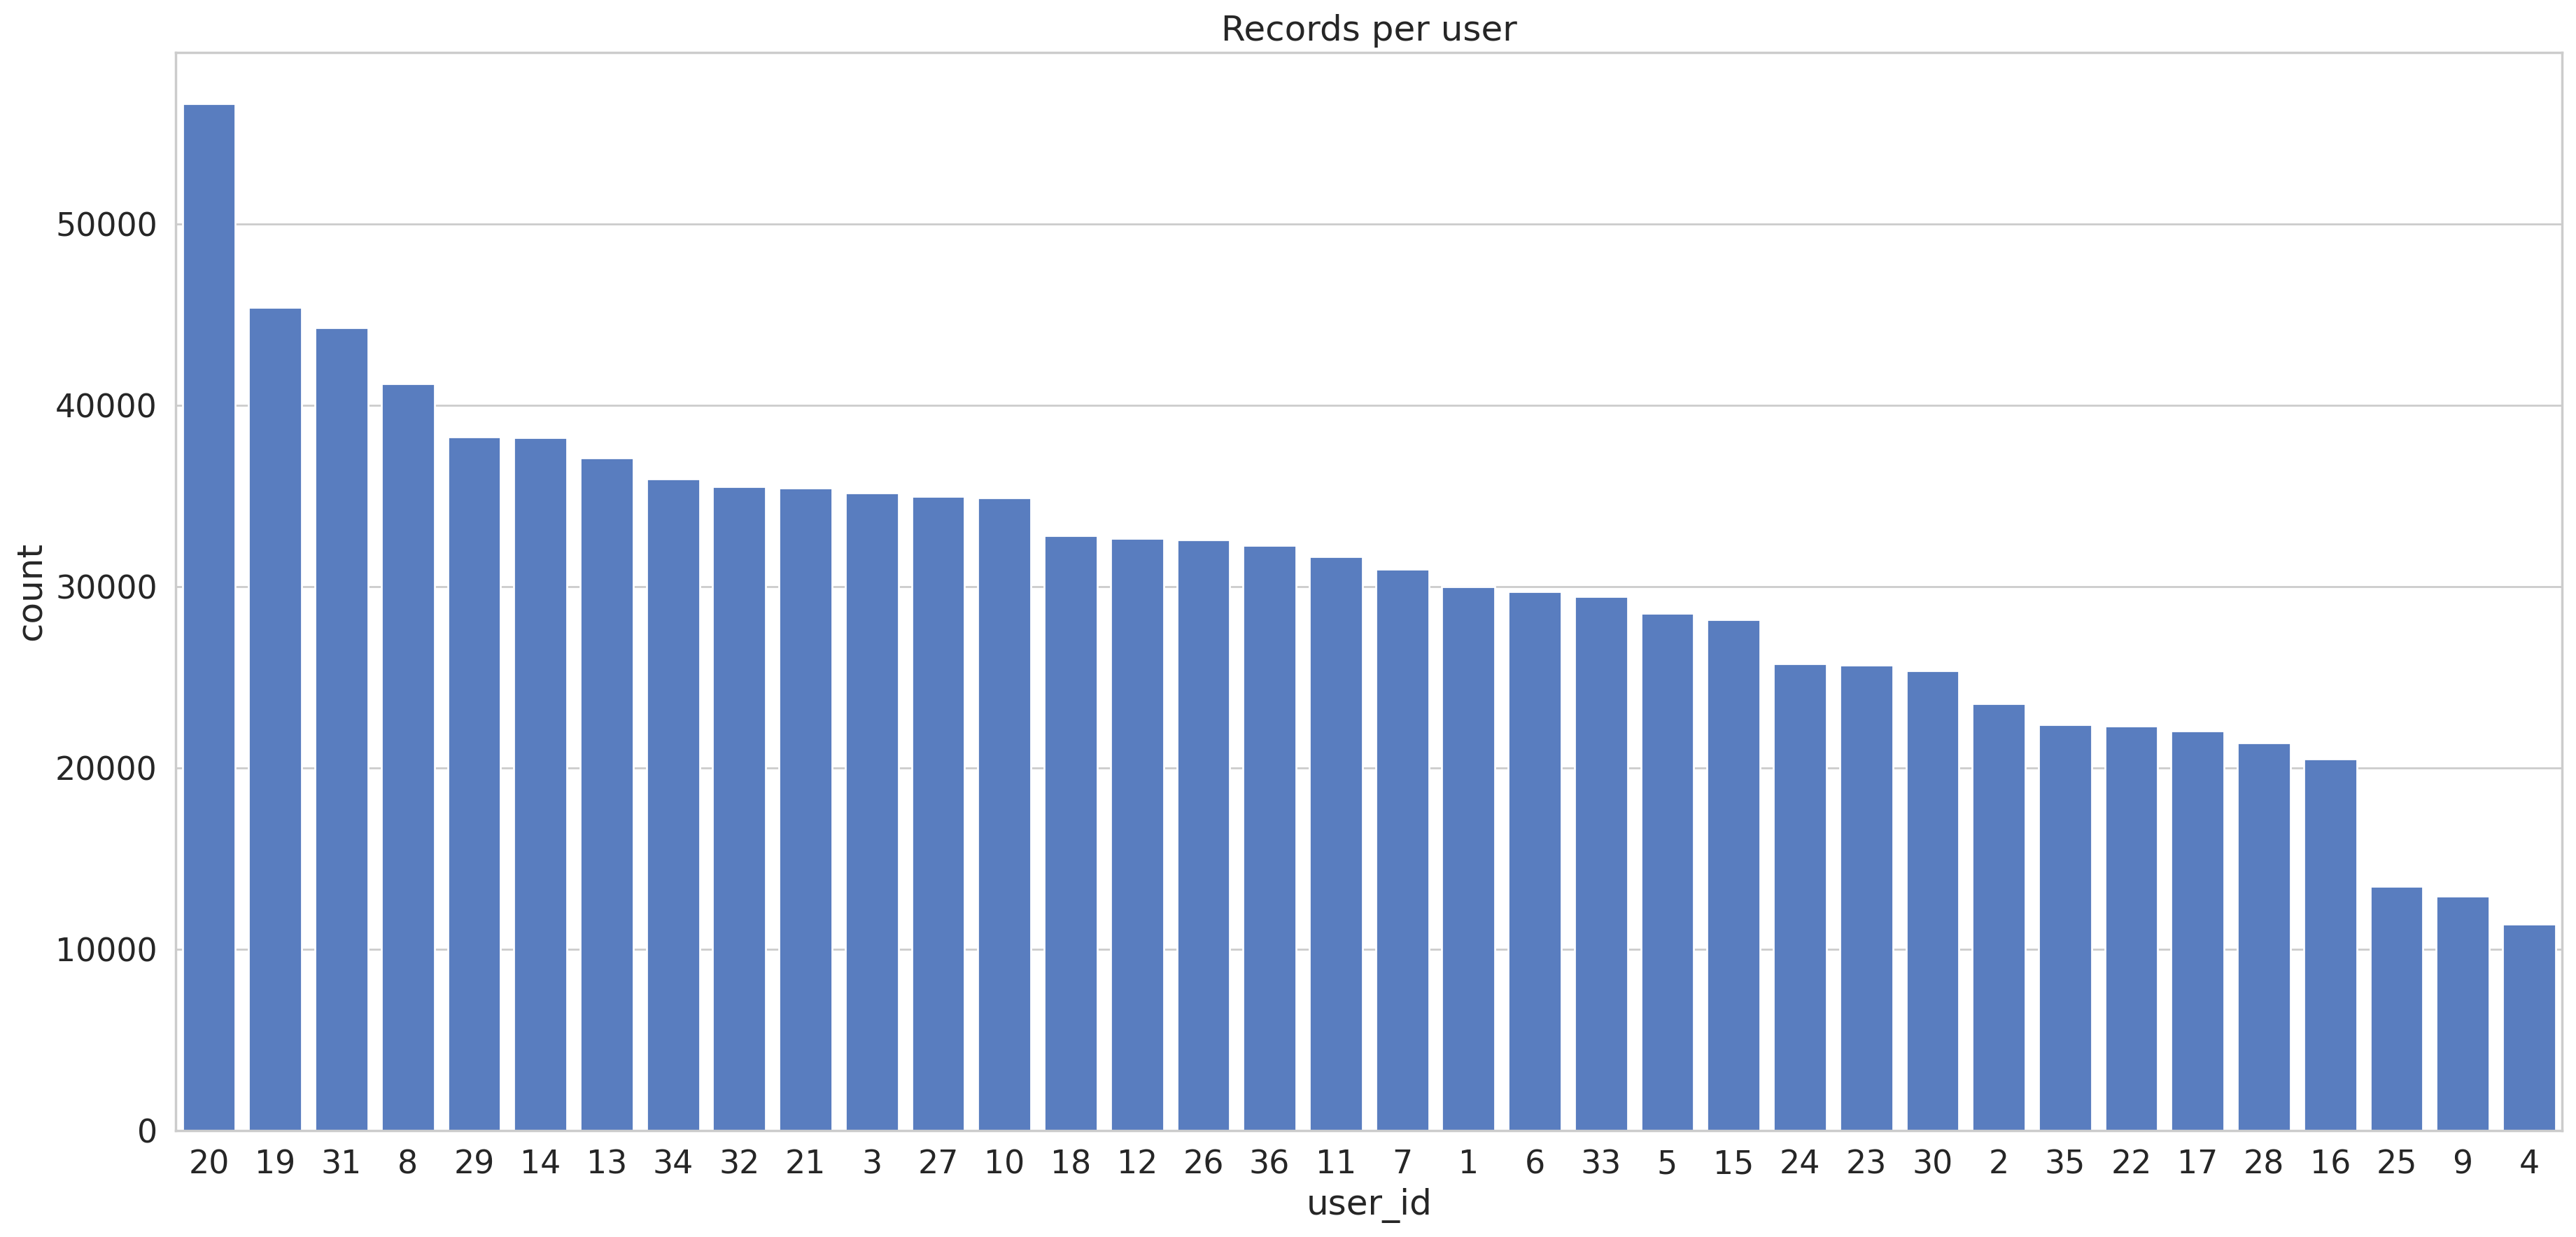

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


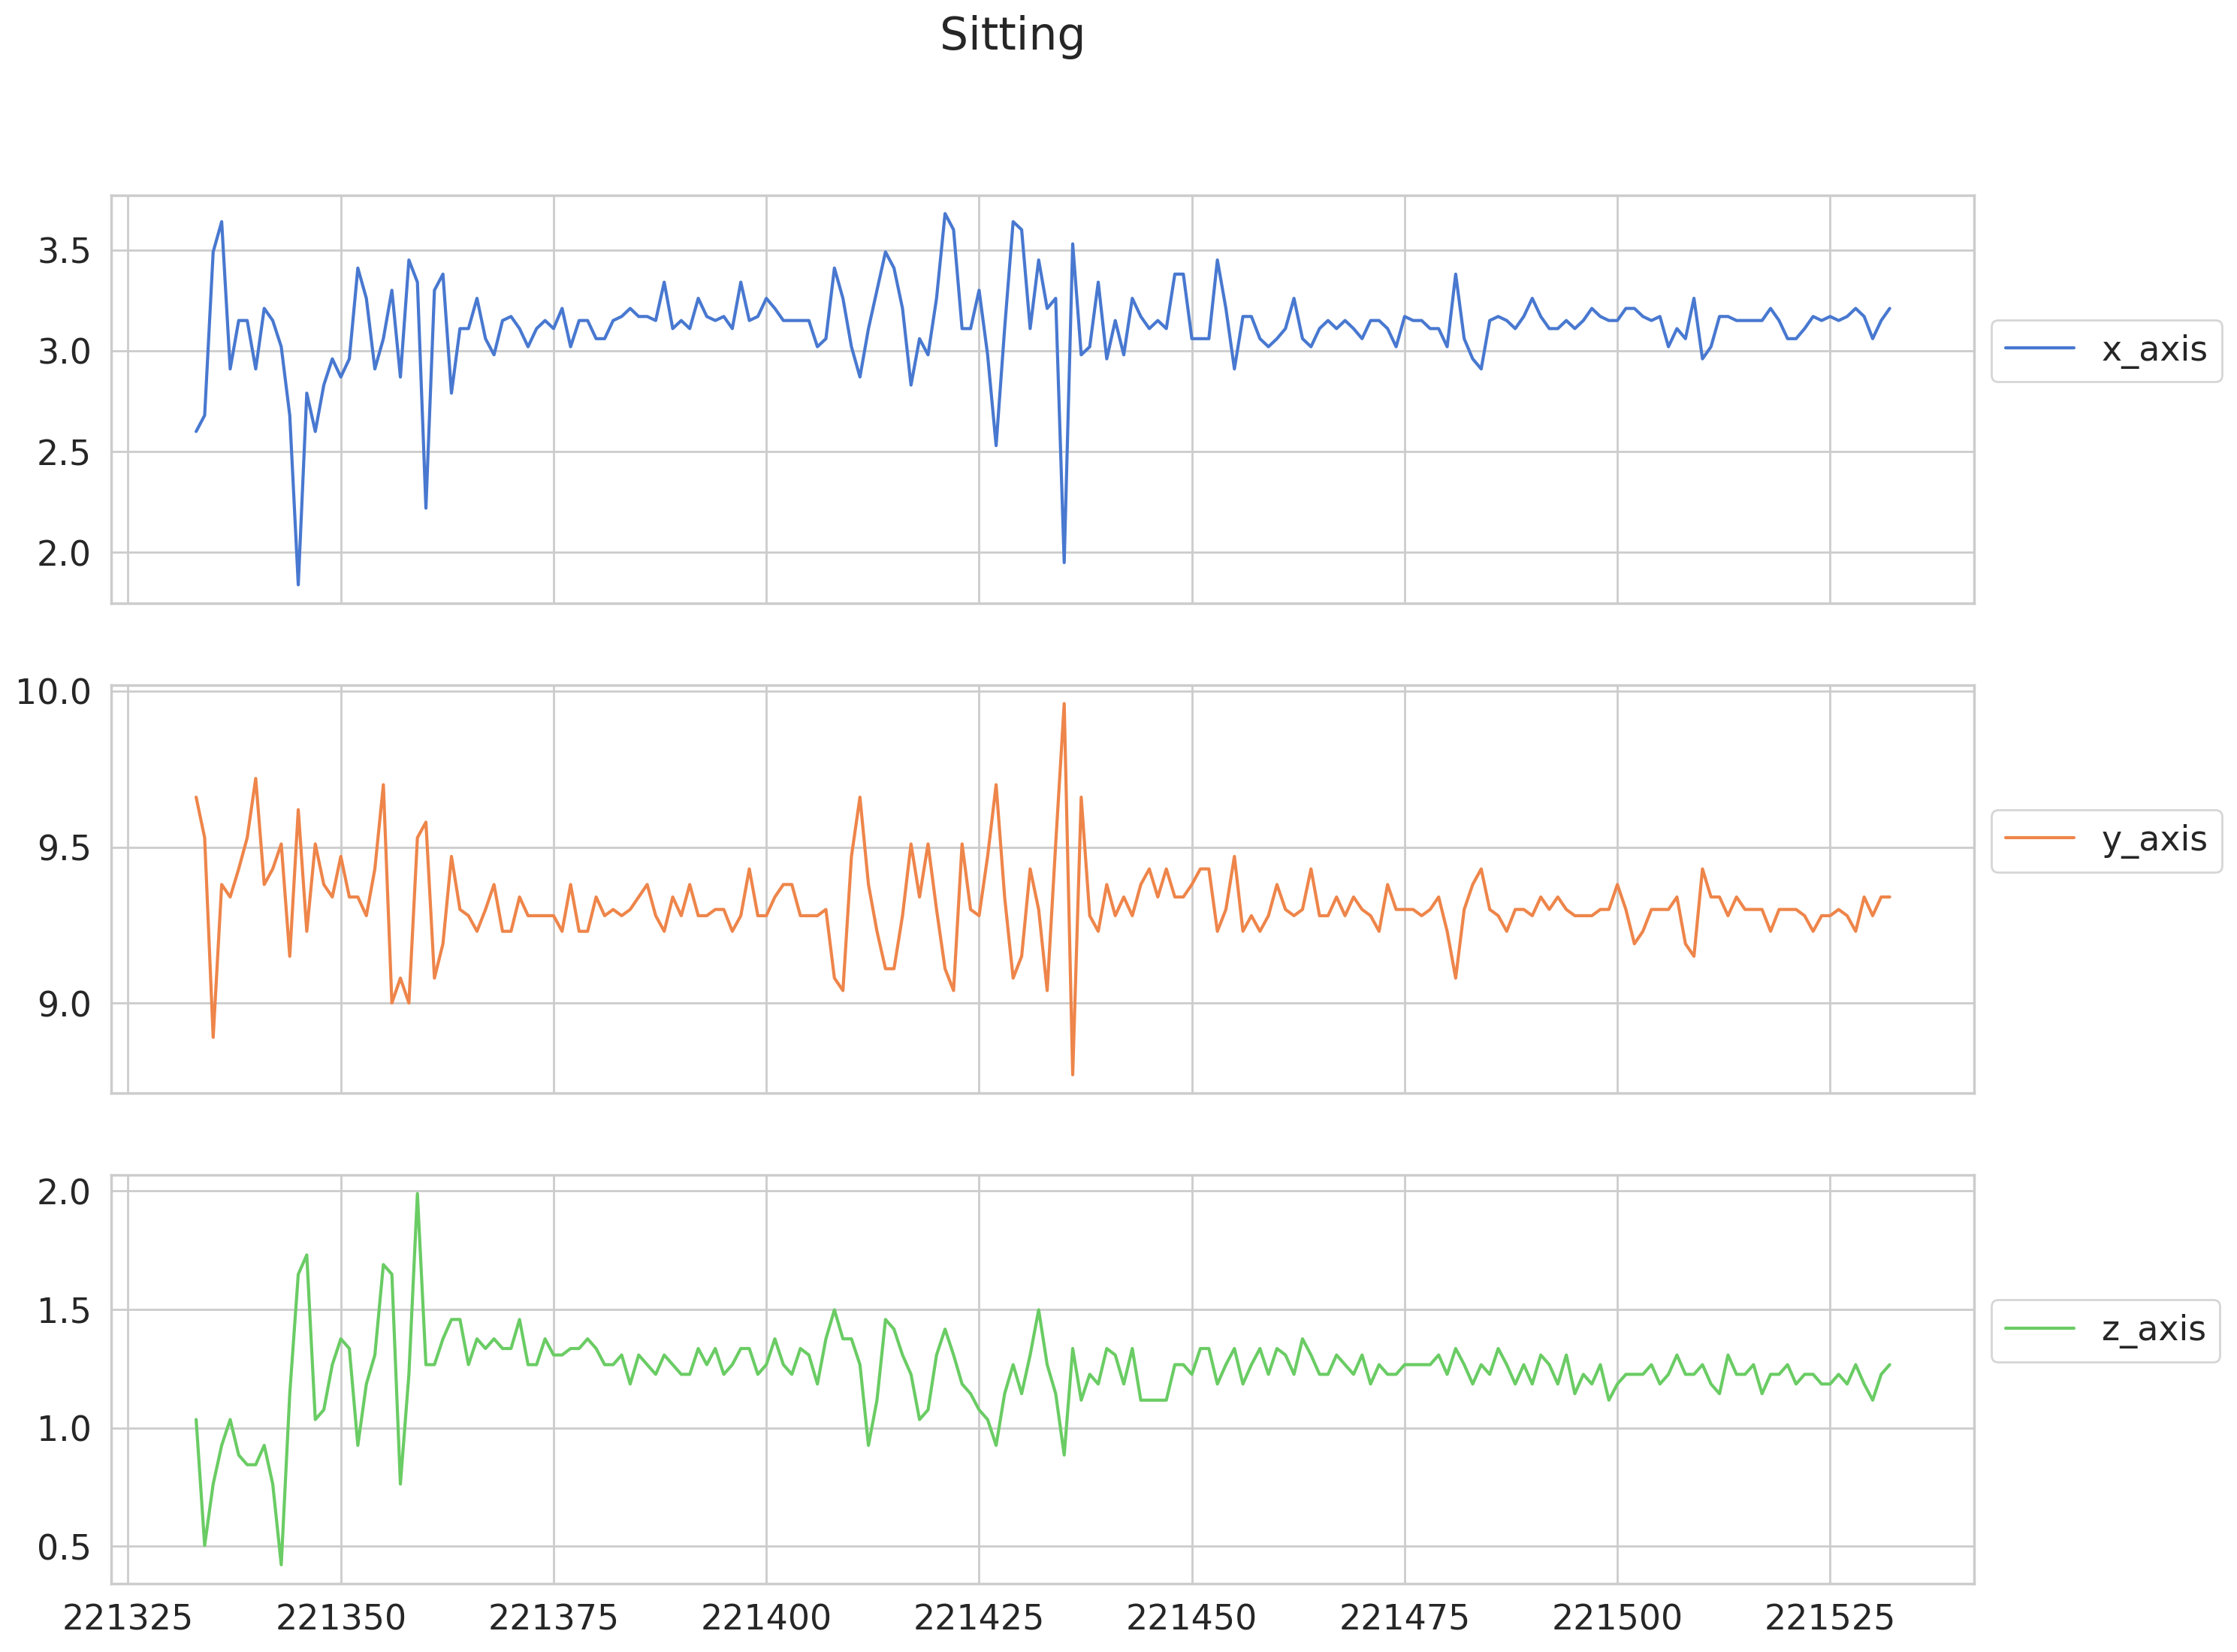

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015   
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001   
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543   
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089   
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.194254 -1.132300  0.342105   
1098201       19  Sitting  131623371431000  1.199726 -1.119190  0.350202   
1098202       19  Sitting  131623411592000  1.205198 -1.109654  0.342105   
1098203       19  Sitting  131623491487000  1.194254 -1.119190  0.350202   
1098204       19  Sitting  131623531465000  1.177839 -1.103695  0.325911   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 200, 3) (17568, 6) (5491, 200, 3) (5491, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

In [13]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 128)               1622144   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1623558 (6.19 MB)
Trainable params: 1623558 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 7s 47ms/step - loss: 0.7888 - accuracy: 0.7337 - val_loss: 0.4876 - val_accuracy: 0.8311
Epoch 2/10
138/138 [==============================] - 5s 34ms/step - loss: 0.3898 - accuracy: 0.8558 - val_loss: 0.3997 - val_accuracy: 0.8538
Epoch 3/10
138/138 [==============================] - 4s 31ms/step - loss: 0.2761 - accuracy: 0.9033 - val_loss: 0.3381 - val_accuracy: 0.8878
Epoch 4/10
138/138 [==============================] - 5s 35ms/step - loss: 0.2067 - accuracy: 0.9300 - val_loss: 0.3166 - val_accuracy: 0.8985
Epoch 5/10
138/138 [==============================] - 5s 35ms/step - loss: 0.1552 - accuracy: 0.9491 - val_loss: 0.3152 - val_accuracy: 0.9012
Epoch 6/10
138/138 [==============================] - 4s 31ms/step - loss: 0.1161 - accuracy: 0.9654 - val_loss: 0.3103 - val_accuracy: 0.8980
Epoch 7/10
138/138 [==============================] - 5s 35ms/step - loss: 0.0827 - accuracy: 0.9783 - val_loss: 0.2933 - val_accuracy: 0.9169

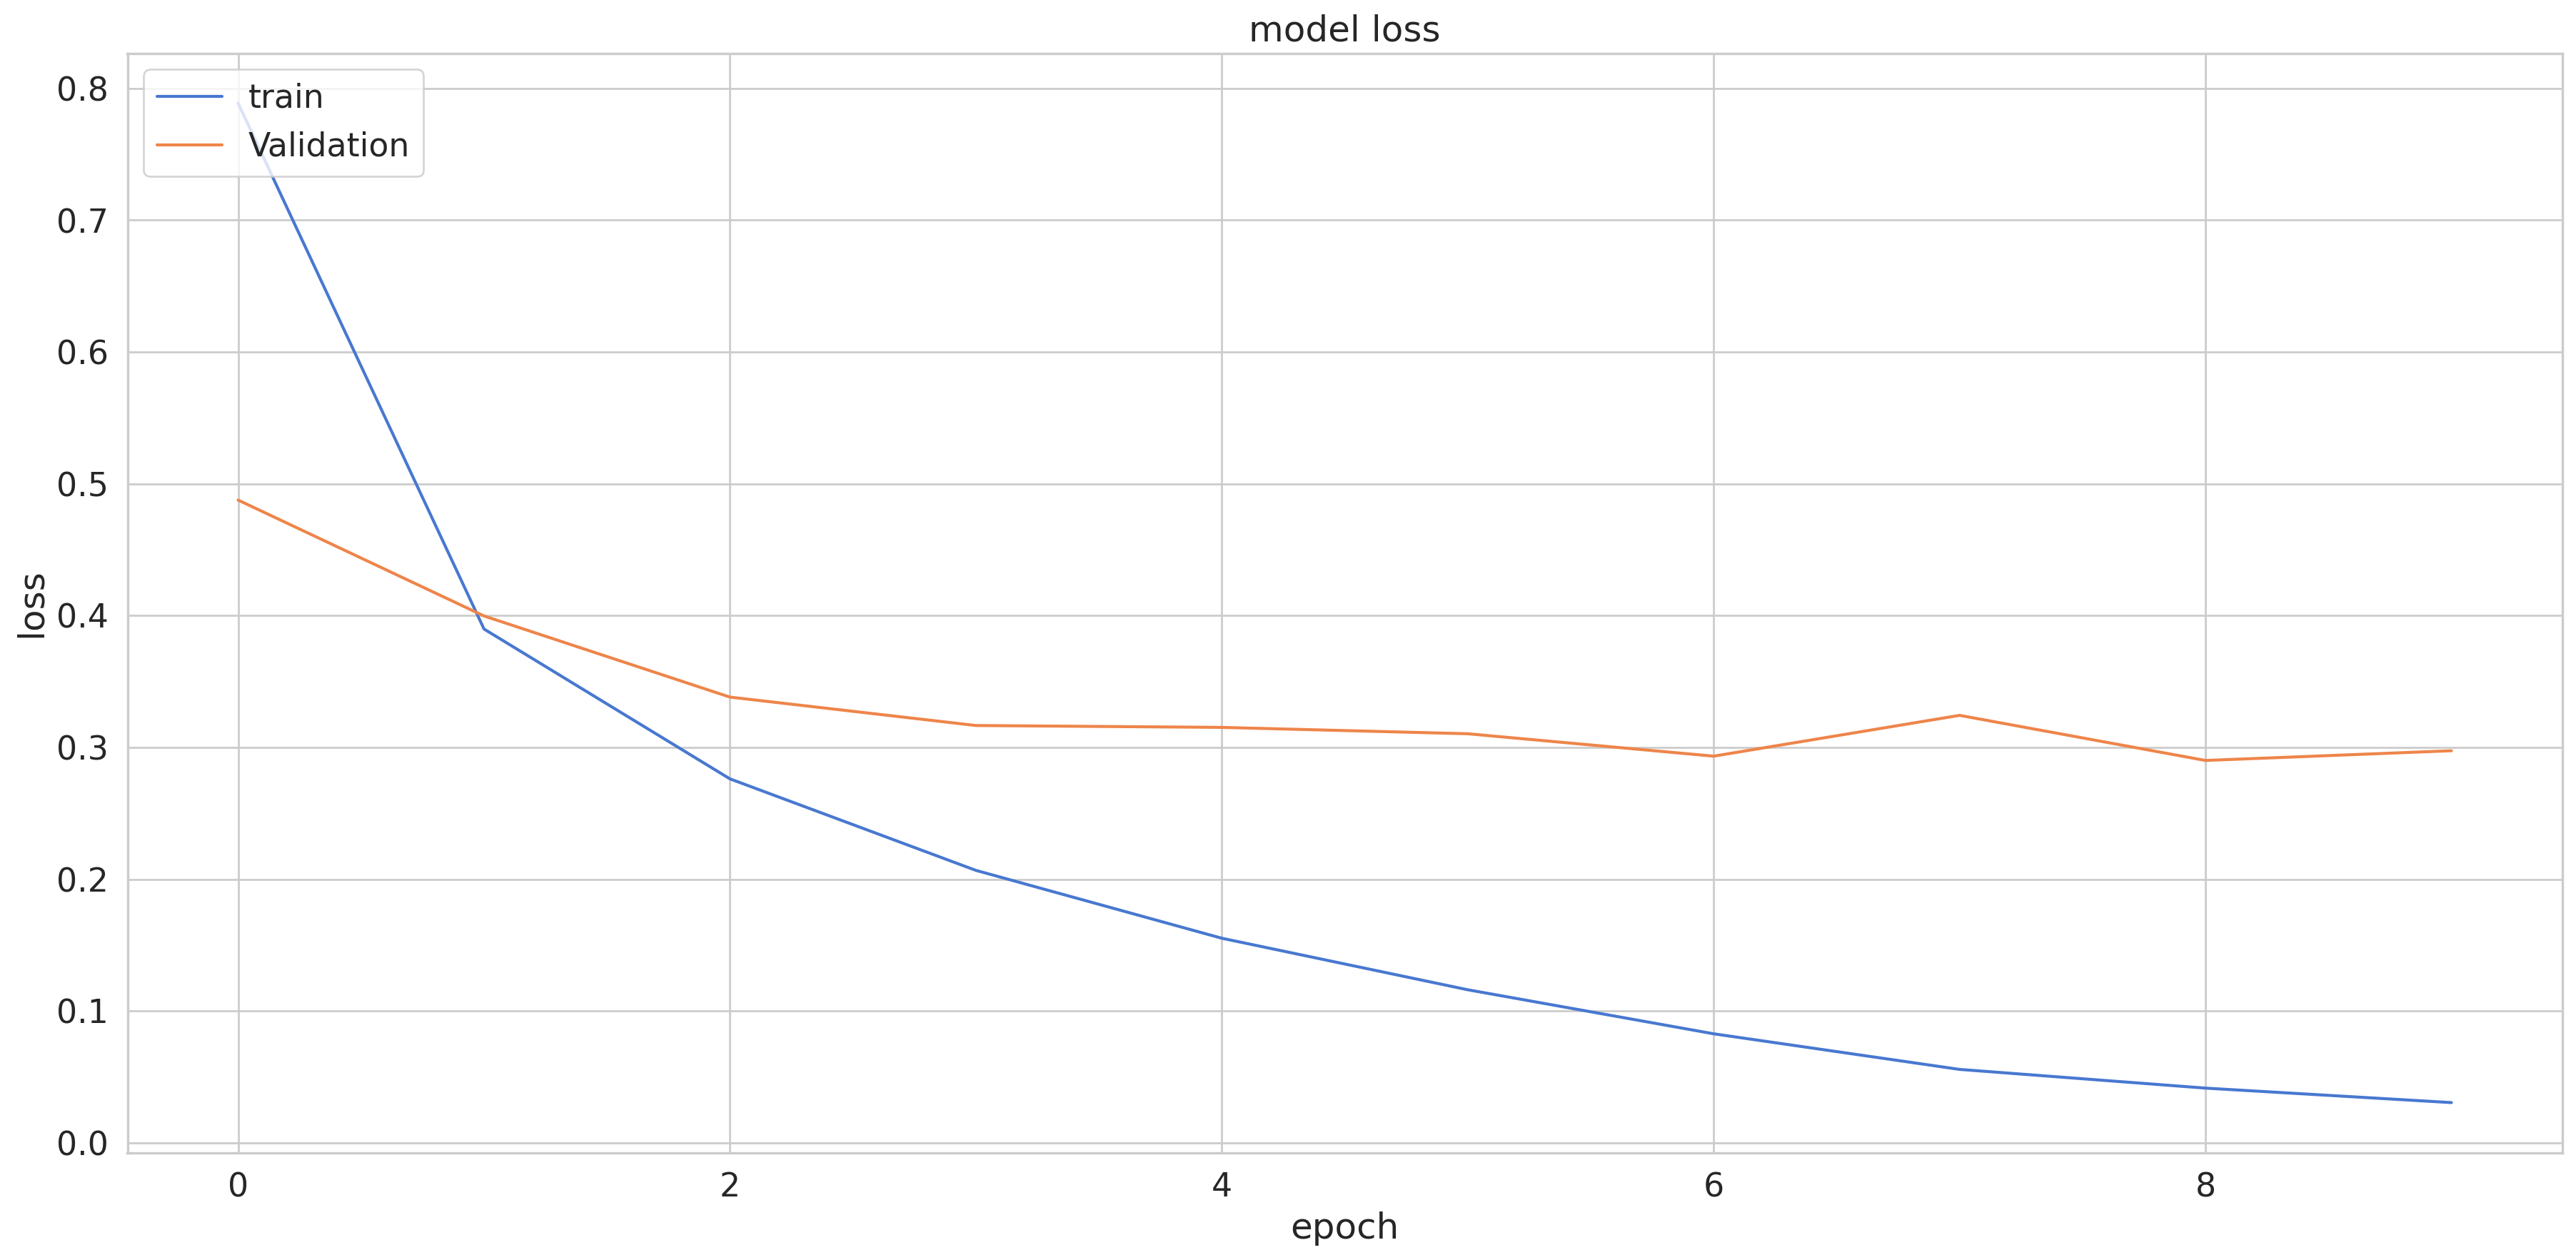

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

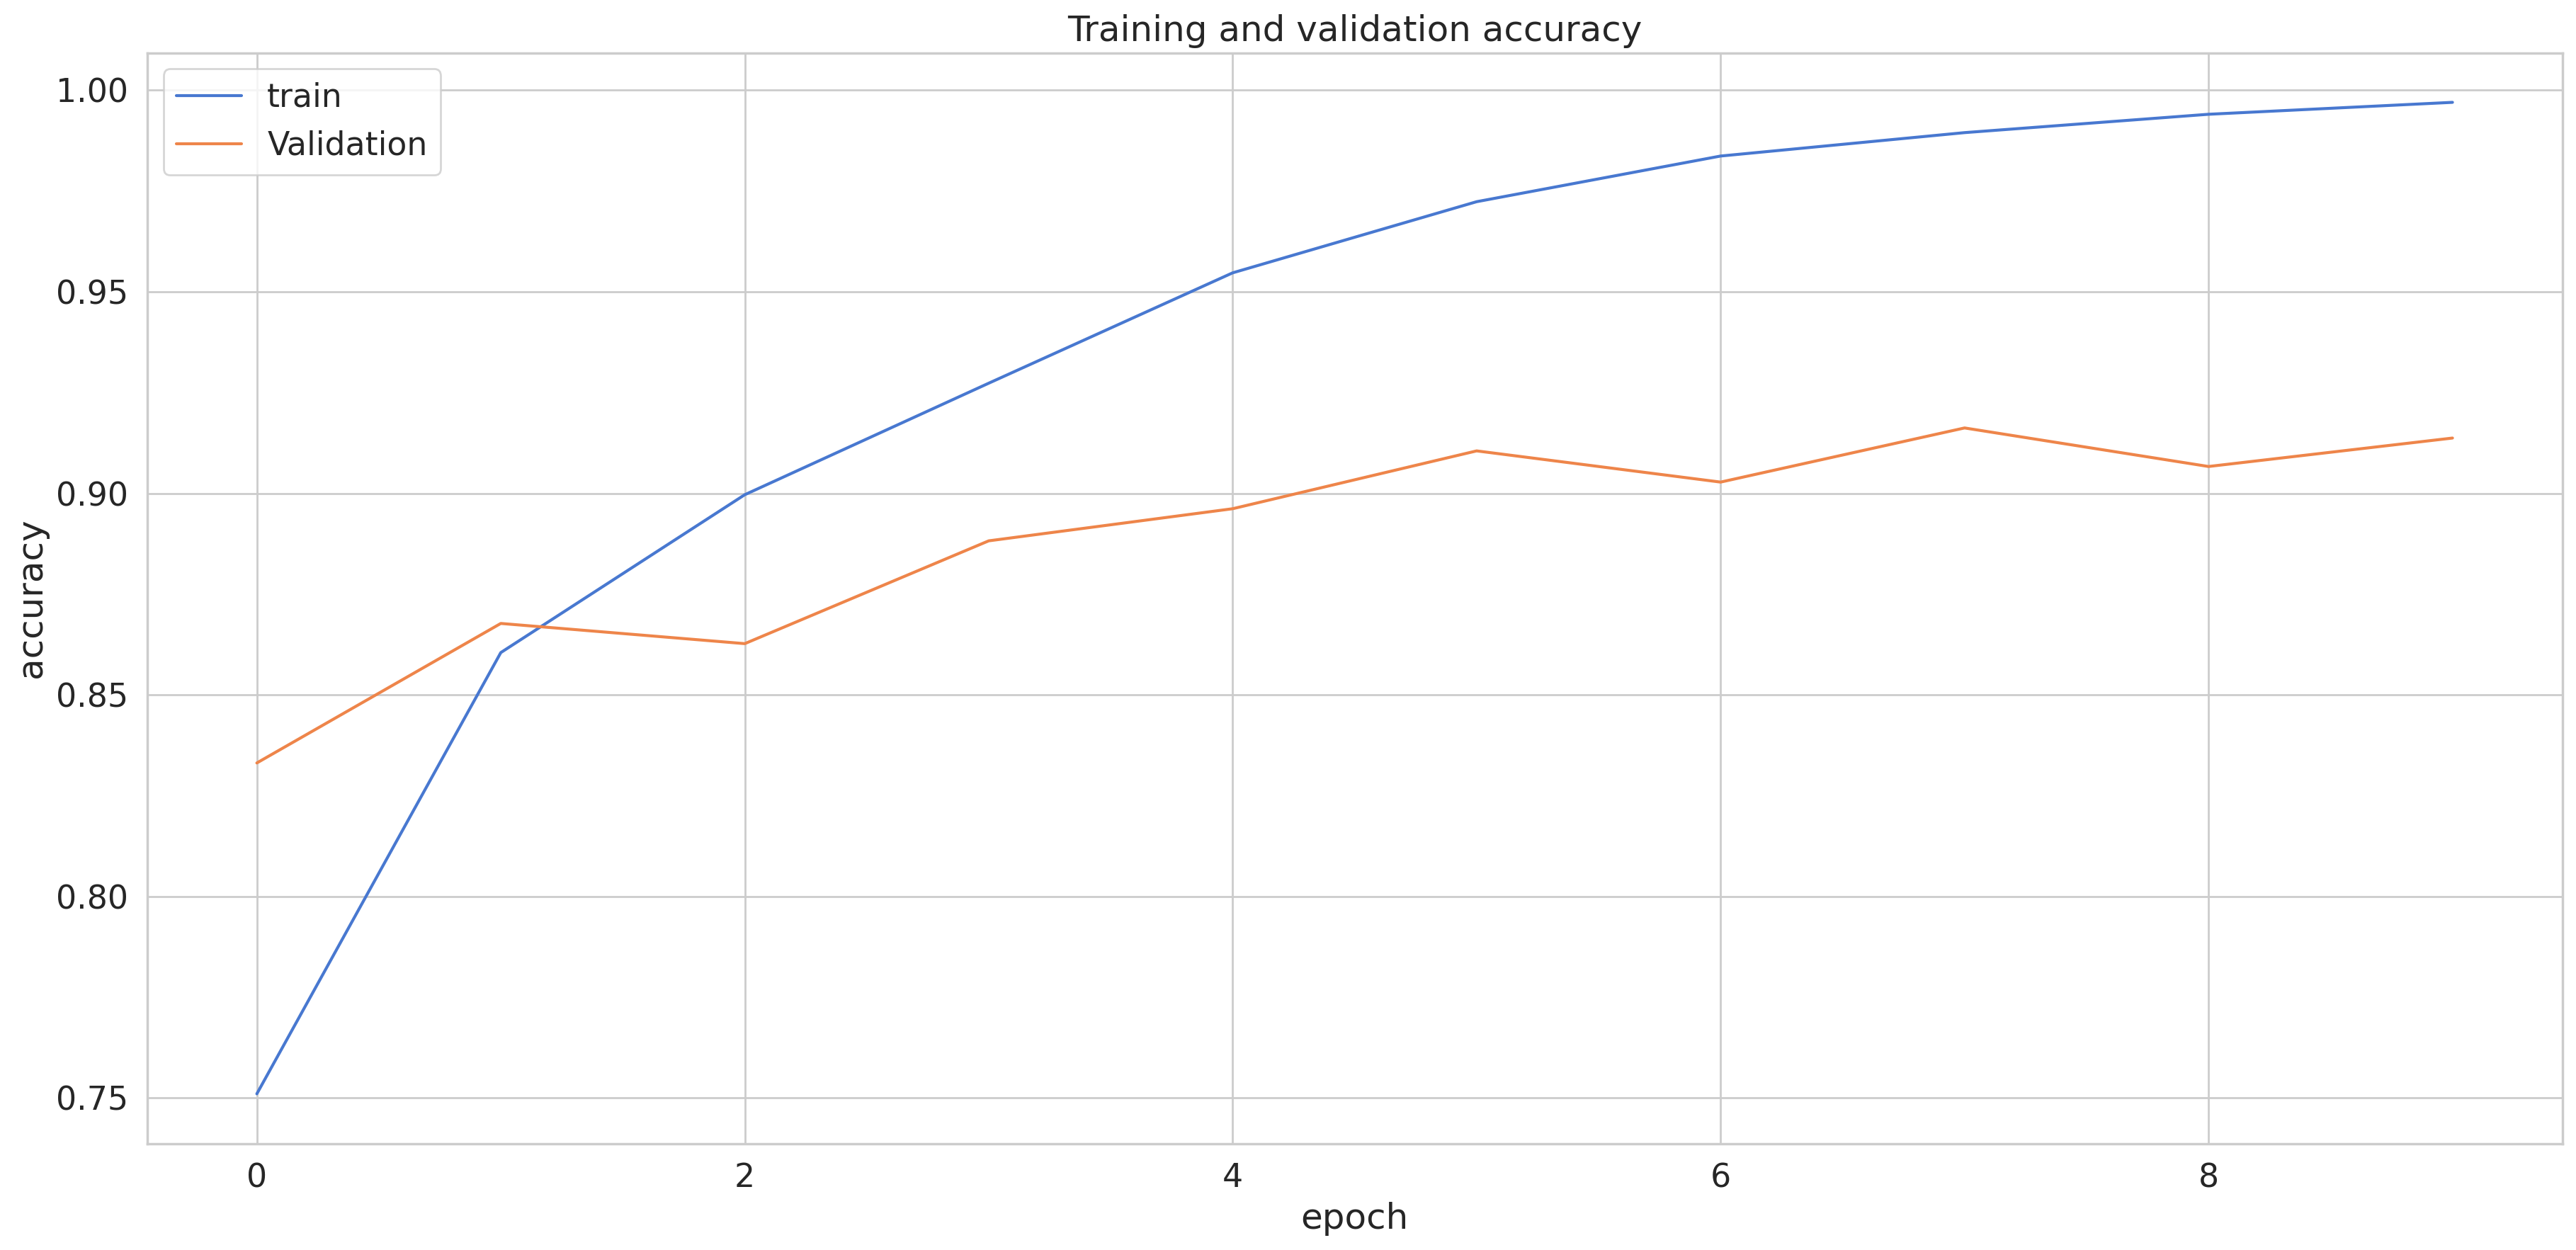

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 2s 10ms/step
f1_score =  0.9058001316964708
0.9074849754143144
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2123
           1       0.96      0.98      0.97      1710
           2       0.68      0.78      0.73       614
           3       0.79      0.57      0.66       503
           4       1.00      0.98      0.99       300
           5       0.99      0.98      0.98       241

    accuracy                           0.91      5491
   macro avg       0.89      0.87      0.88      5491
weighted avg       0.91      0.91      0.91      5491



<Axes: >

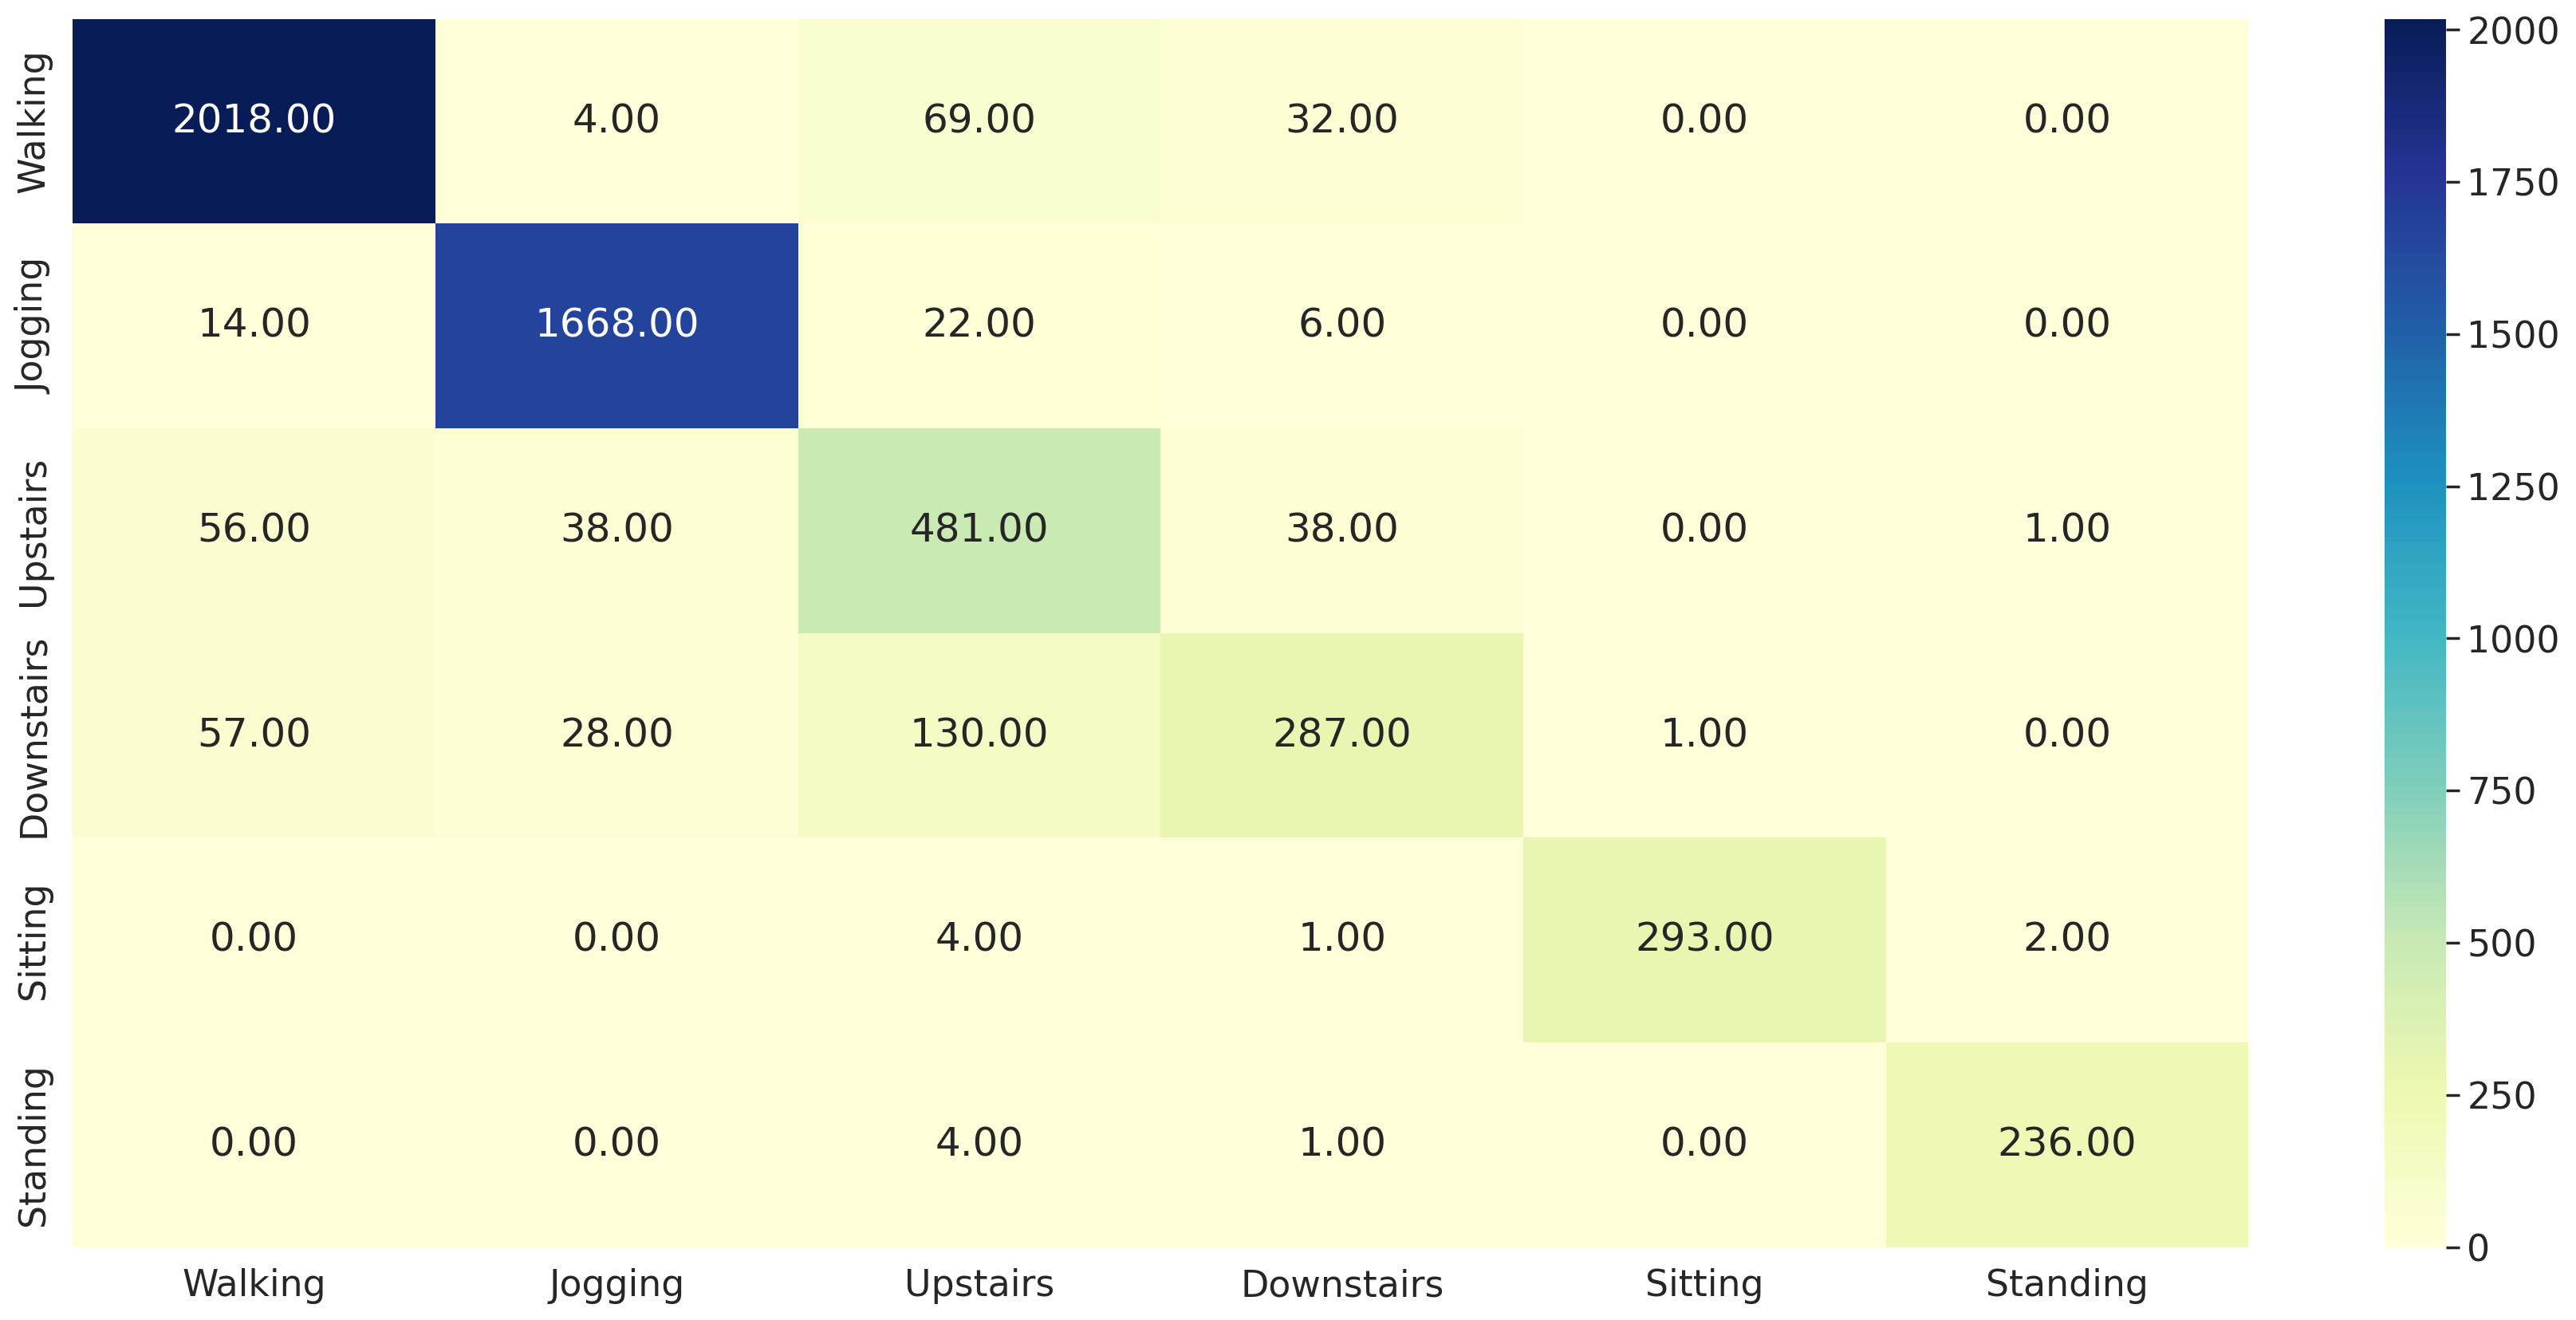

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_8 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               1605760   
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1619526 (6.18 MB)
Trainable params: 1619526 (6.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 19s 131ms/step - loss: 0.6740 - accuracy: 0.7505 - val_loss: 0.3952 - val_accuracy: 0.8488
Epoch 2/10
138/138 [==============================] - 16s 118ms/step - loss: 0.2692 - accuracy: 0.9065 - val_loss: 0.2376 - val_accuracy: 0.9164
Epoch 3/10
138/138 [==============================] - 16s 119ms/step - loss: 0.1520 - accuracy: 0.9506 - val_loss: 0.2272 - val_accuracy: 0.9251
Epoch 4/10
138/138 [==============================] - 16s 116ms/step - loss: 0.1027 - accuracy: 0.9692 - val_loss: 0.1743 - val_accuracy: 0.9417
Epoch 5/10
138/138 [==============================] - 16s 119ms/step - loss: 0.0724 - accuracy: 0.9801 - val_loss: 0.1684 - val_accuracy: 0.9499
Epoch 6/10
138/138 [==============================] - 16s 119ms/step - loss: 0.0431 - accuracy: 0.9894 - val_loss: 0.1453 - val_accuracy: 0.9540
Epoch 7/10
138/138 [==============================] - 16s 119ms/step - loss: 0.0241 - accuracy: 0.9959 - val_loss: 0.1545 - val_ac

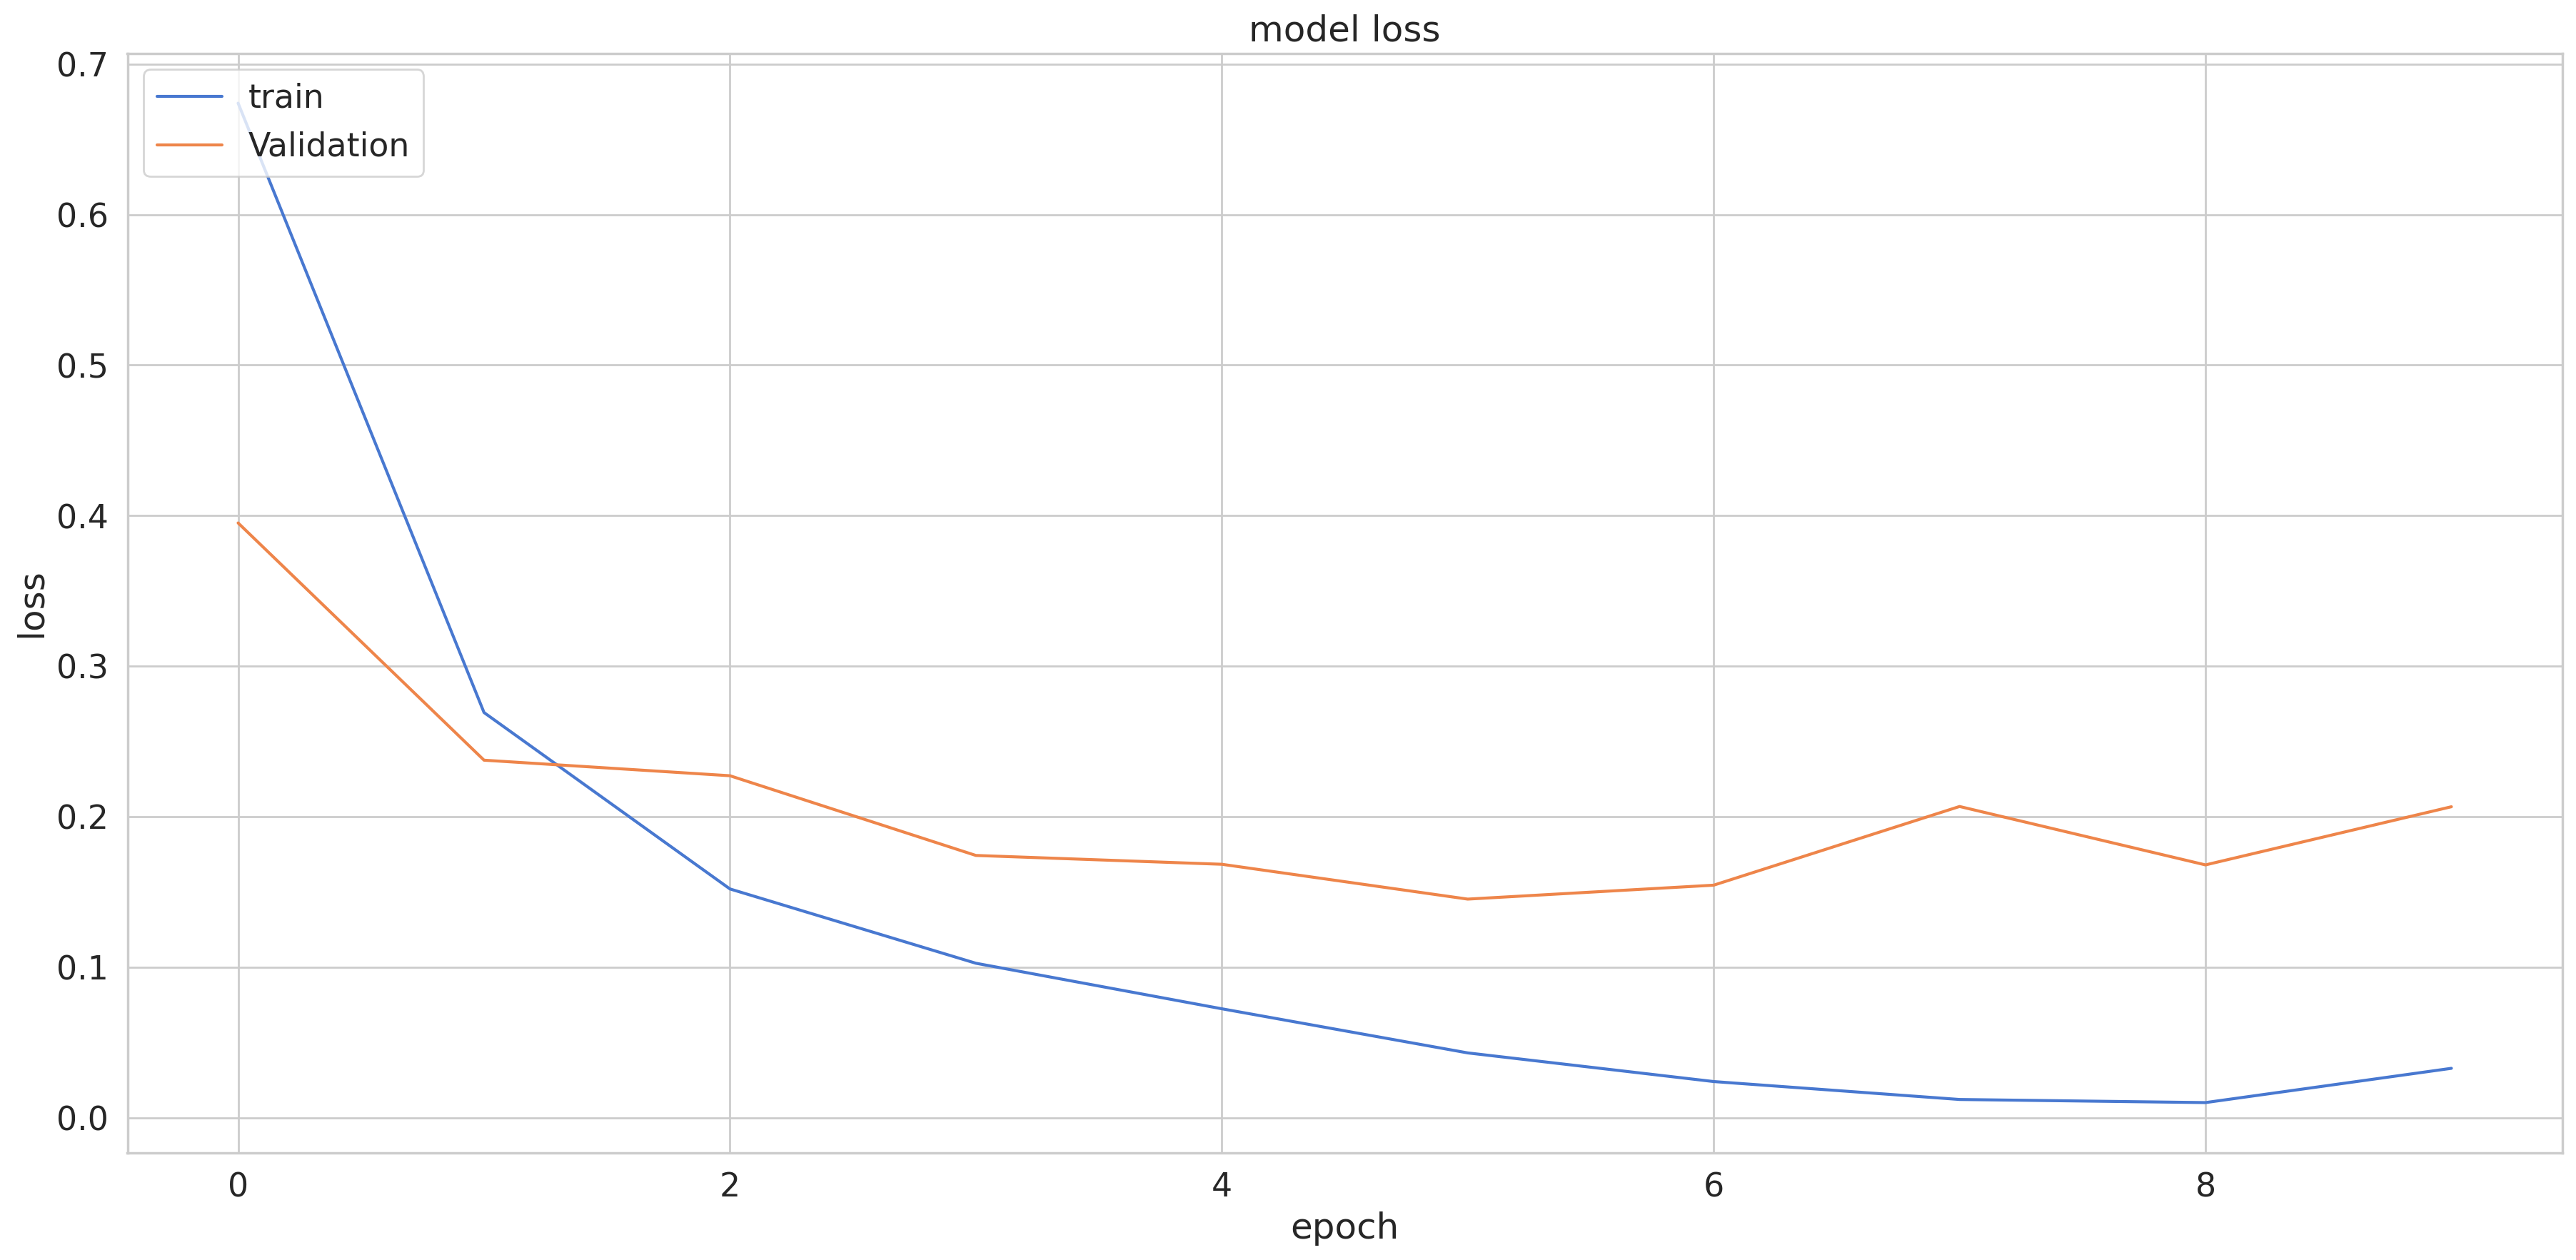

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

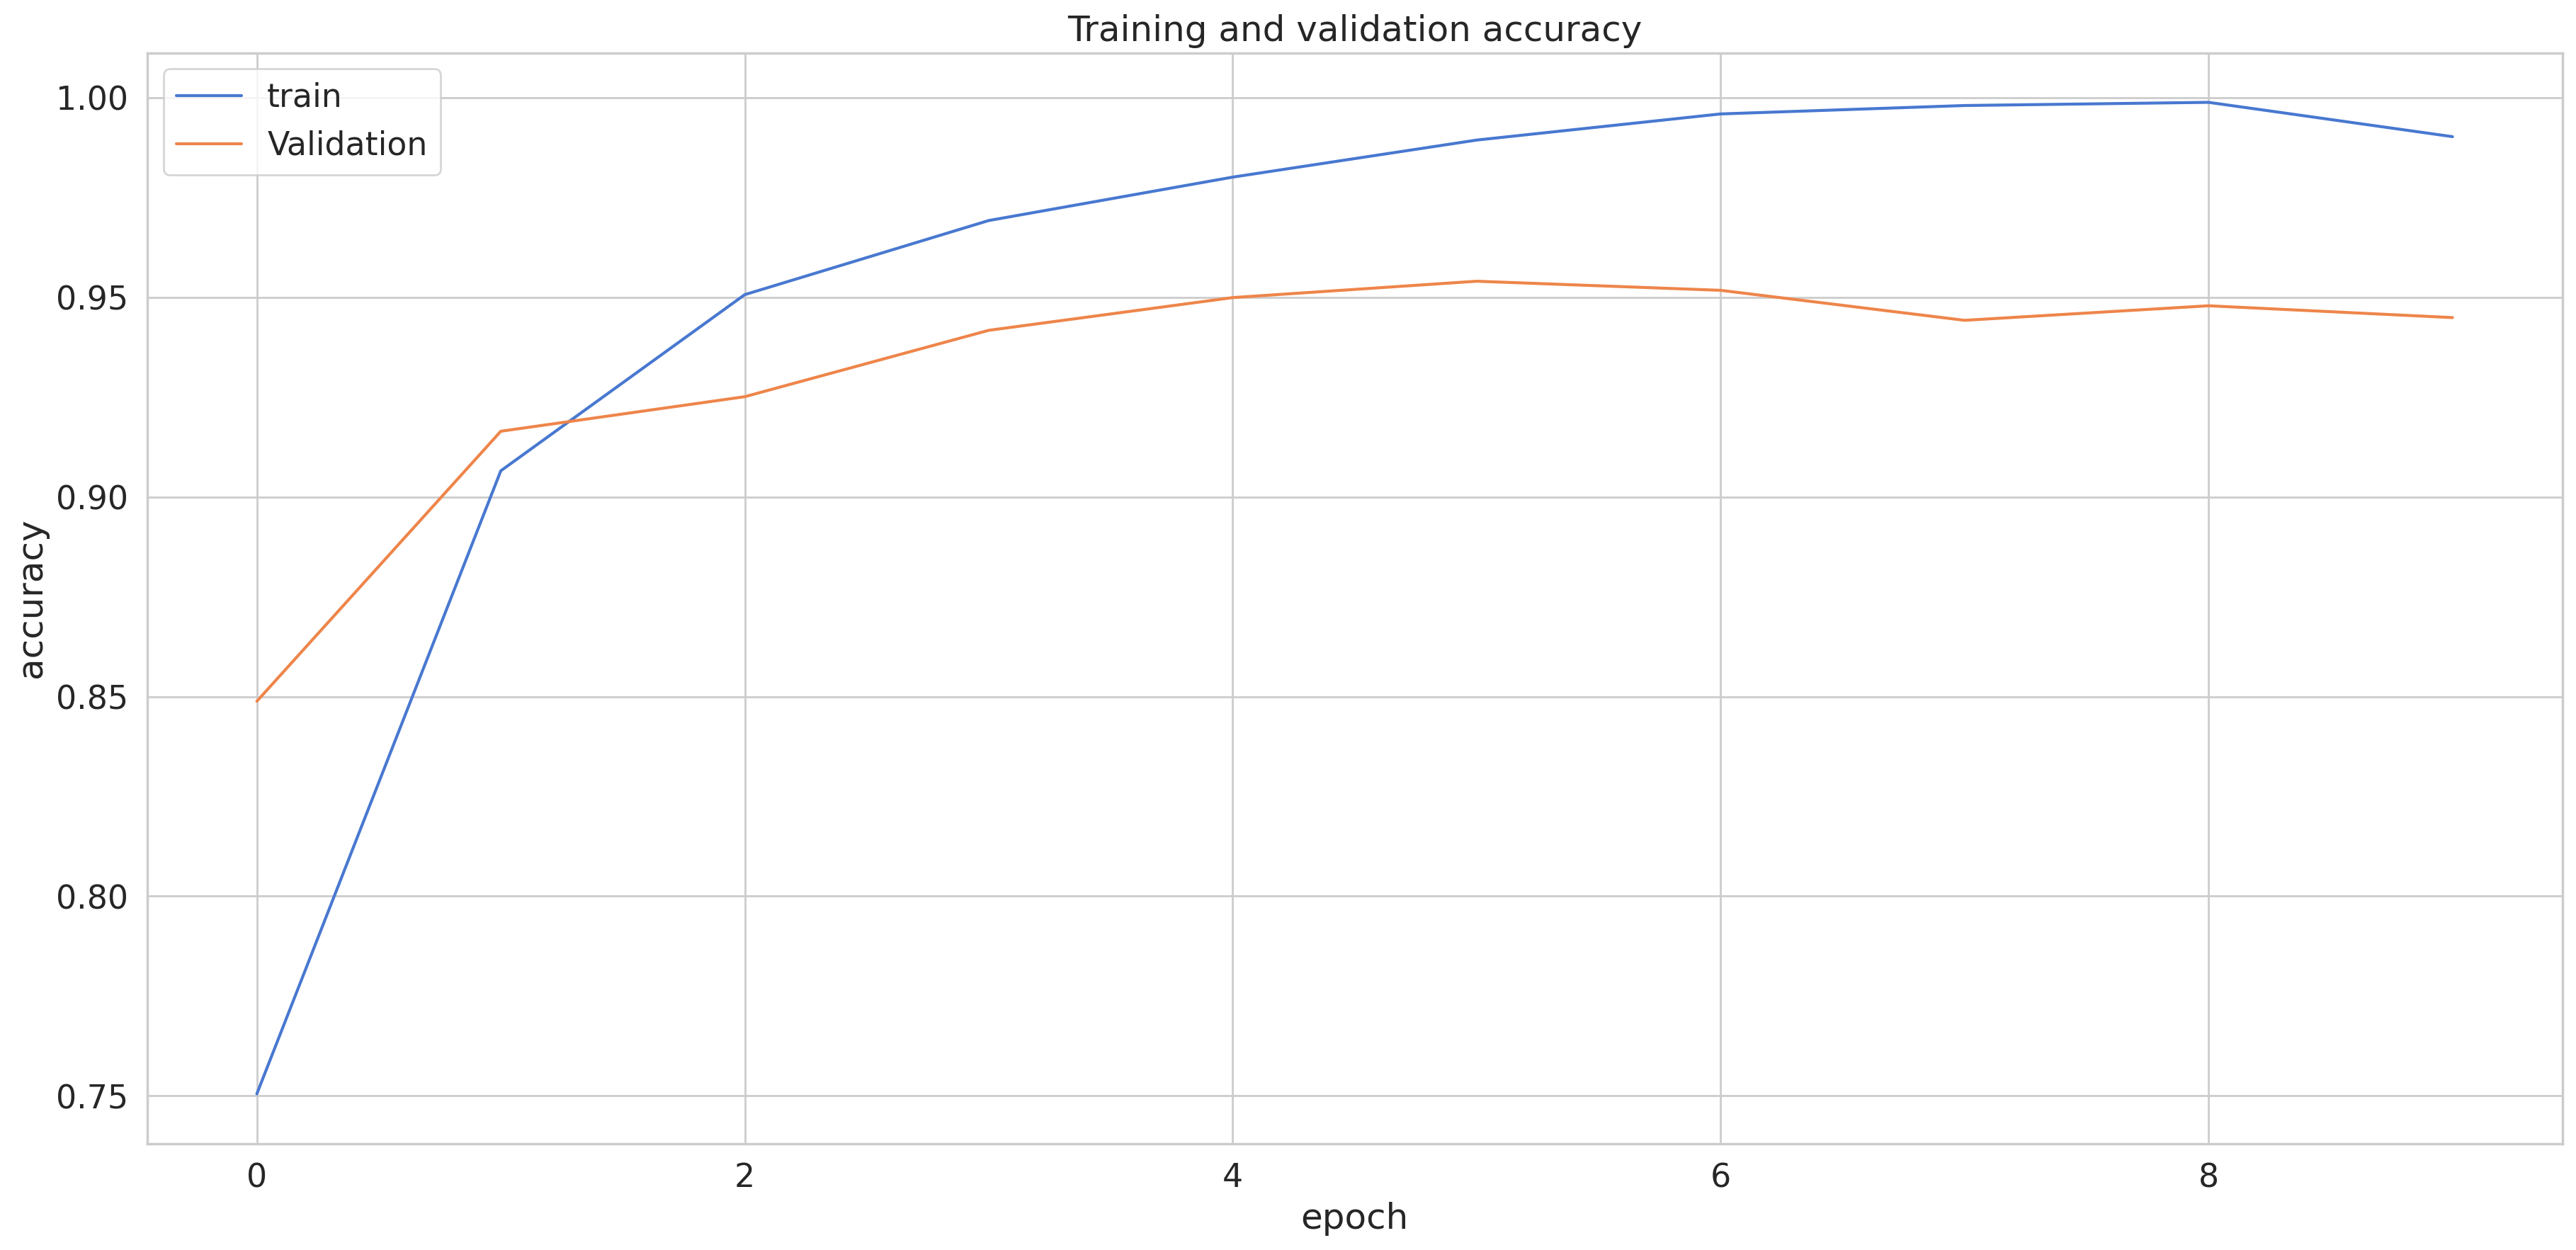

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 14ms/step
f1_score =  0.9432441224716142
0.9448187943908214
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2123
           1       0.96      0.99      0.97      1710
           2       0.86      0.78      0.82       614
           3       0.86      0.78      0.82       503
           4       0.98      0.98      0.98       300
           5       0.99      0.96      0.97       241

    accuracy                           0.94      5491
   macro avg       0.94      0.91      0.92      5491
weighted avg       0.94      0.94      0.94      5491



<Axes: >

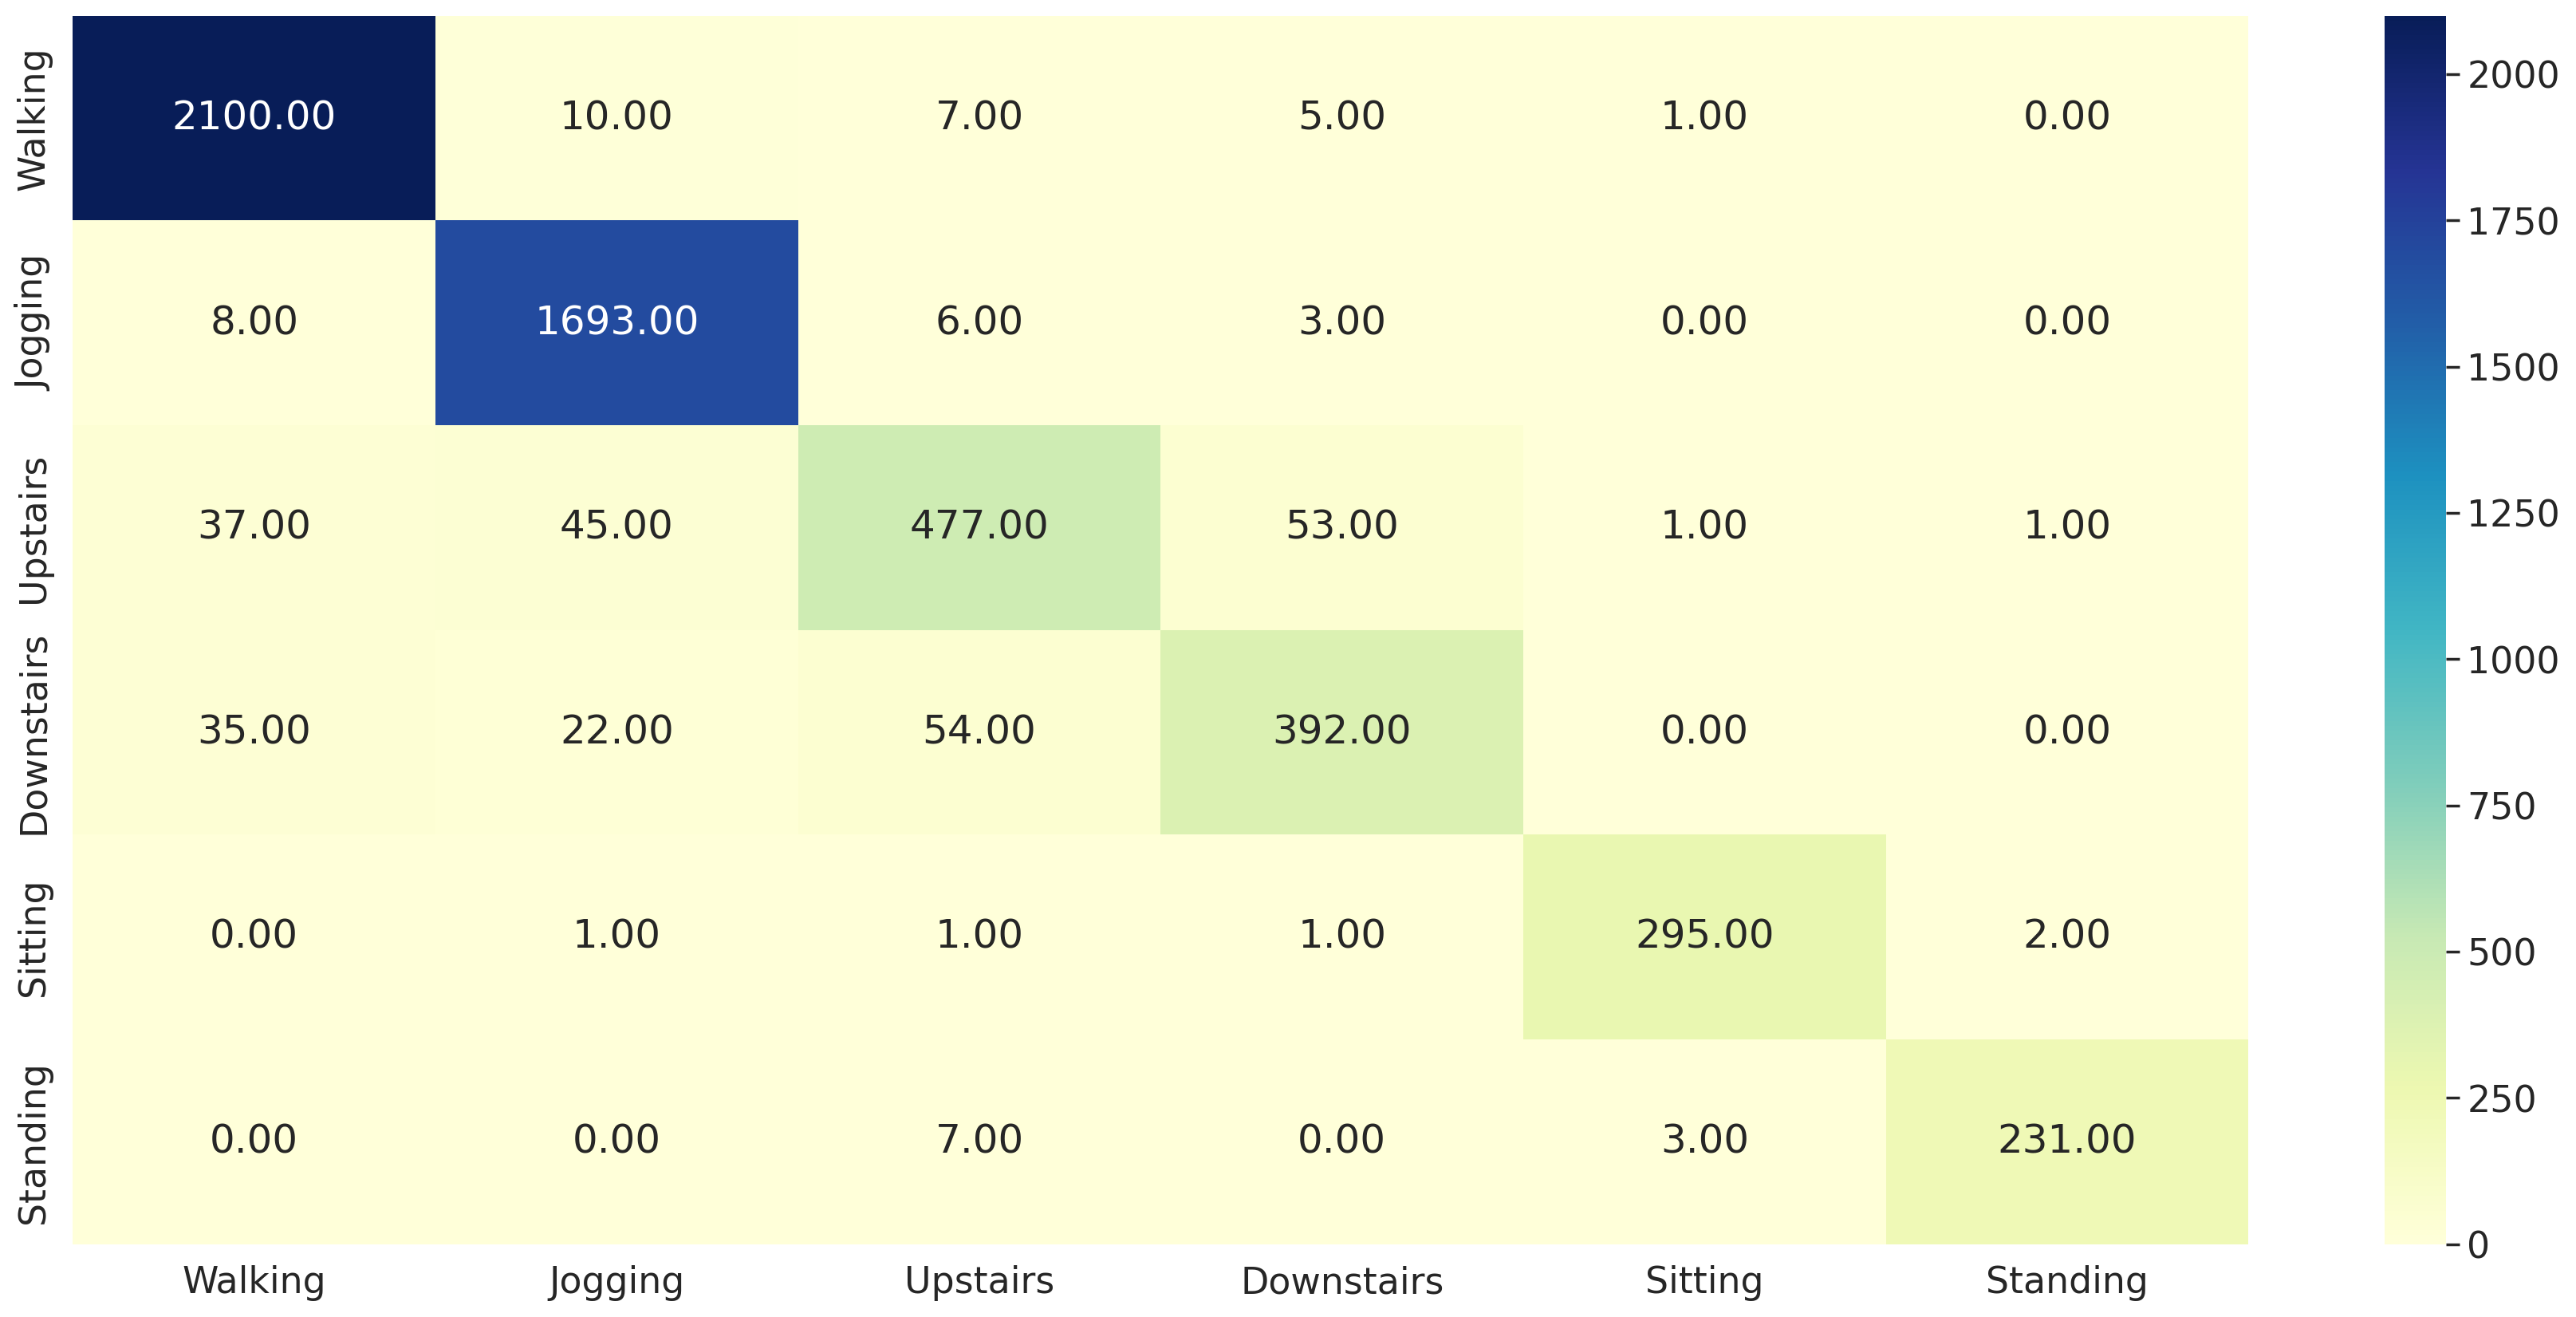

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_10 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 conv1d_11 (Conv1D)          (None, 194, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 97, 64)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 6208)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               794752    
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 22s 151ms/step - loss: 0.6190 - accuracy: 0.7642 - val_loss: 0.3202 - val_accuracy: 0.8891
Epoch 2/10
138/138 [==============================] - 23s 164ms/step - loss: 0.2271 - accuracy: 0.9242 - val_loss: 0.2420 - val_accuracy: 0.9224
Epoch 3/10
138/138 [==============================] - 20s 148ms/step - loss: 0.1285 - accuracy: 0.9579 - val_loss: 0.1427 - val_accuracy: 0.9540
Epoch 4/10
138/138 [==============================] - 23s 166ms/step - loss: 0.0816 - accuracy: 0.9744 - val_loss: 0.1327 - val_accuracy: 0.9597
Epoch 5/10
138/138 [==============================] - 20s 148ms/step - loss: 0.0687 - accuracy: 0.9781 - val_loss: 0.1015 - val_accuracy: 0.9643
Epoch 6/10
138/138 [==============================] - 22s 158ms/step - loss: 0.0338 - accuracy: 0.9906 - val_loss: 0.0920 - val_accuracy: 0.9702
Epoch 7/10
138/138 [==============================] - 21s 154ms/step - loss: 0.0287 - accuracy: 0.9921 - val_loss: 0.0927 - val_ac

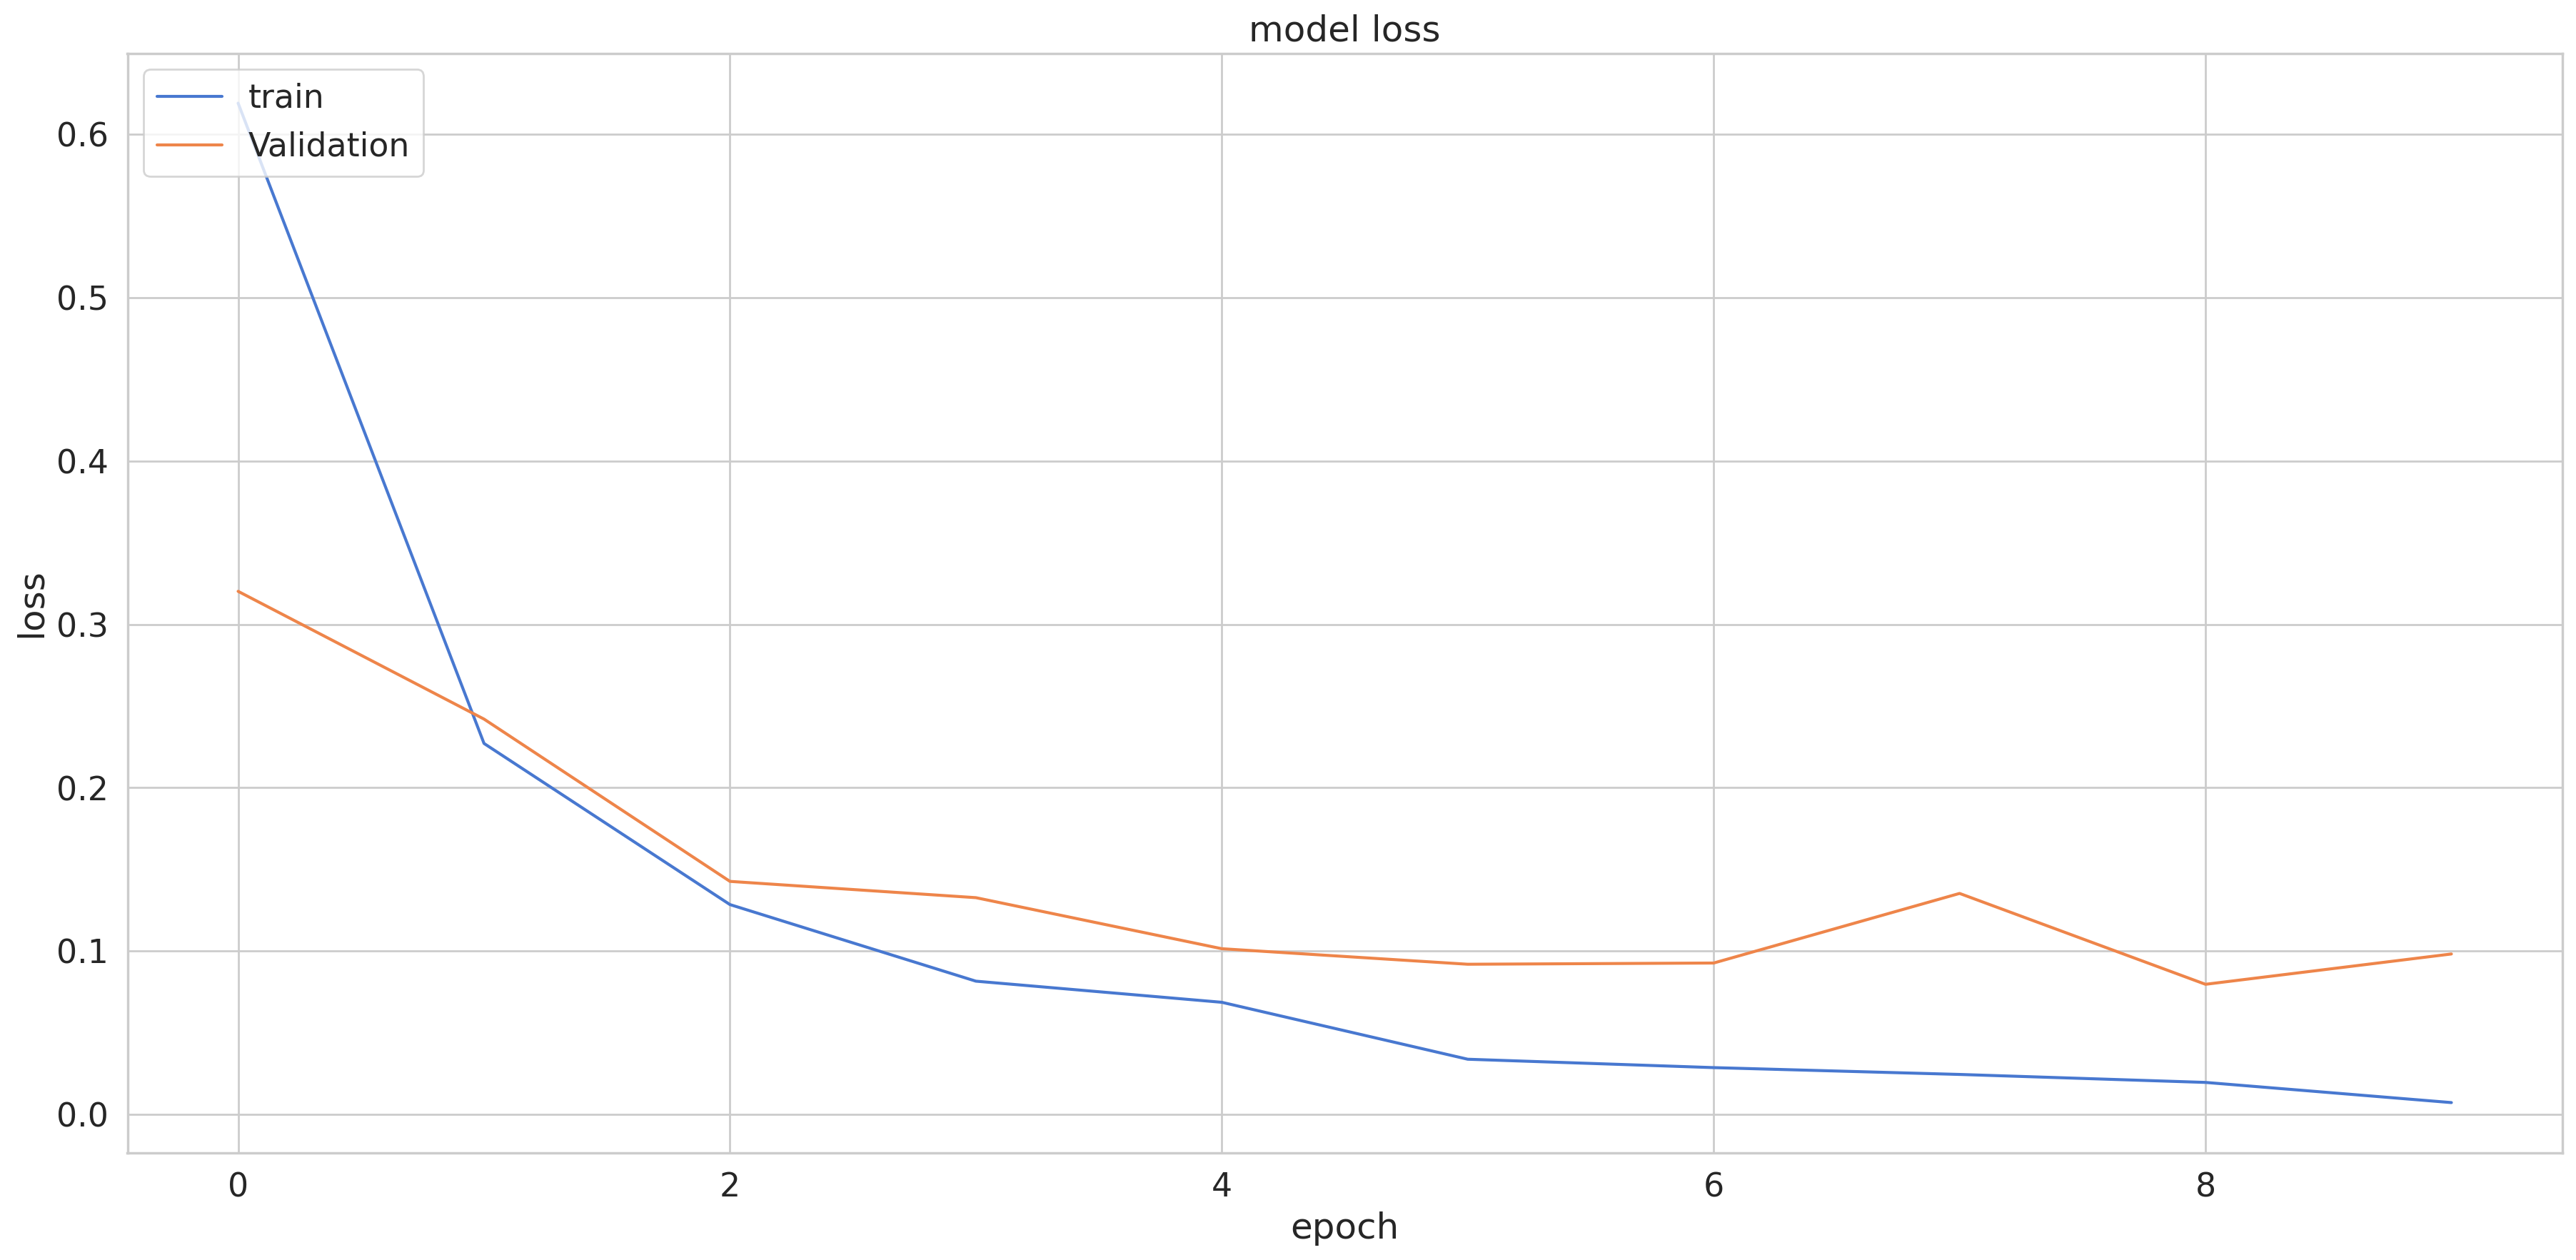

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

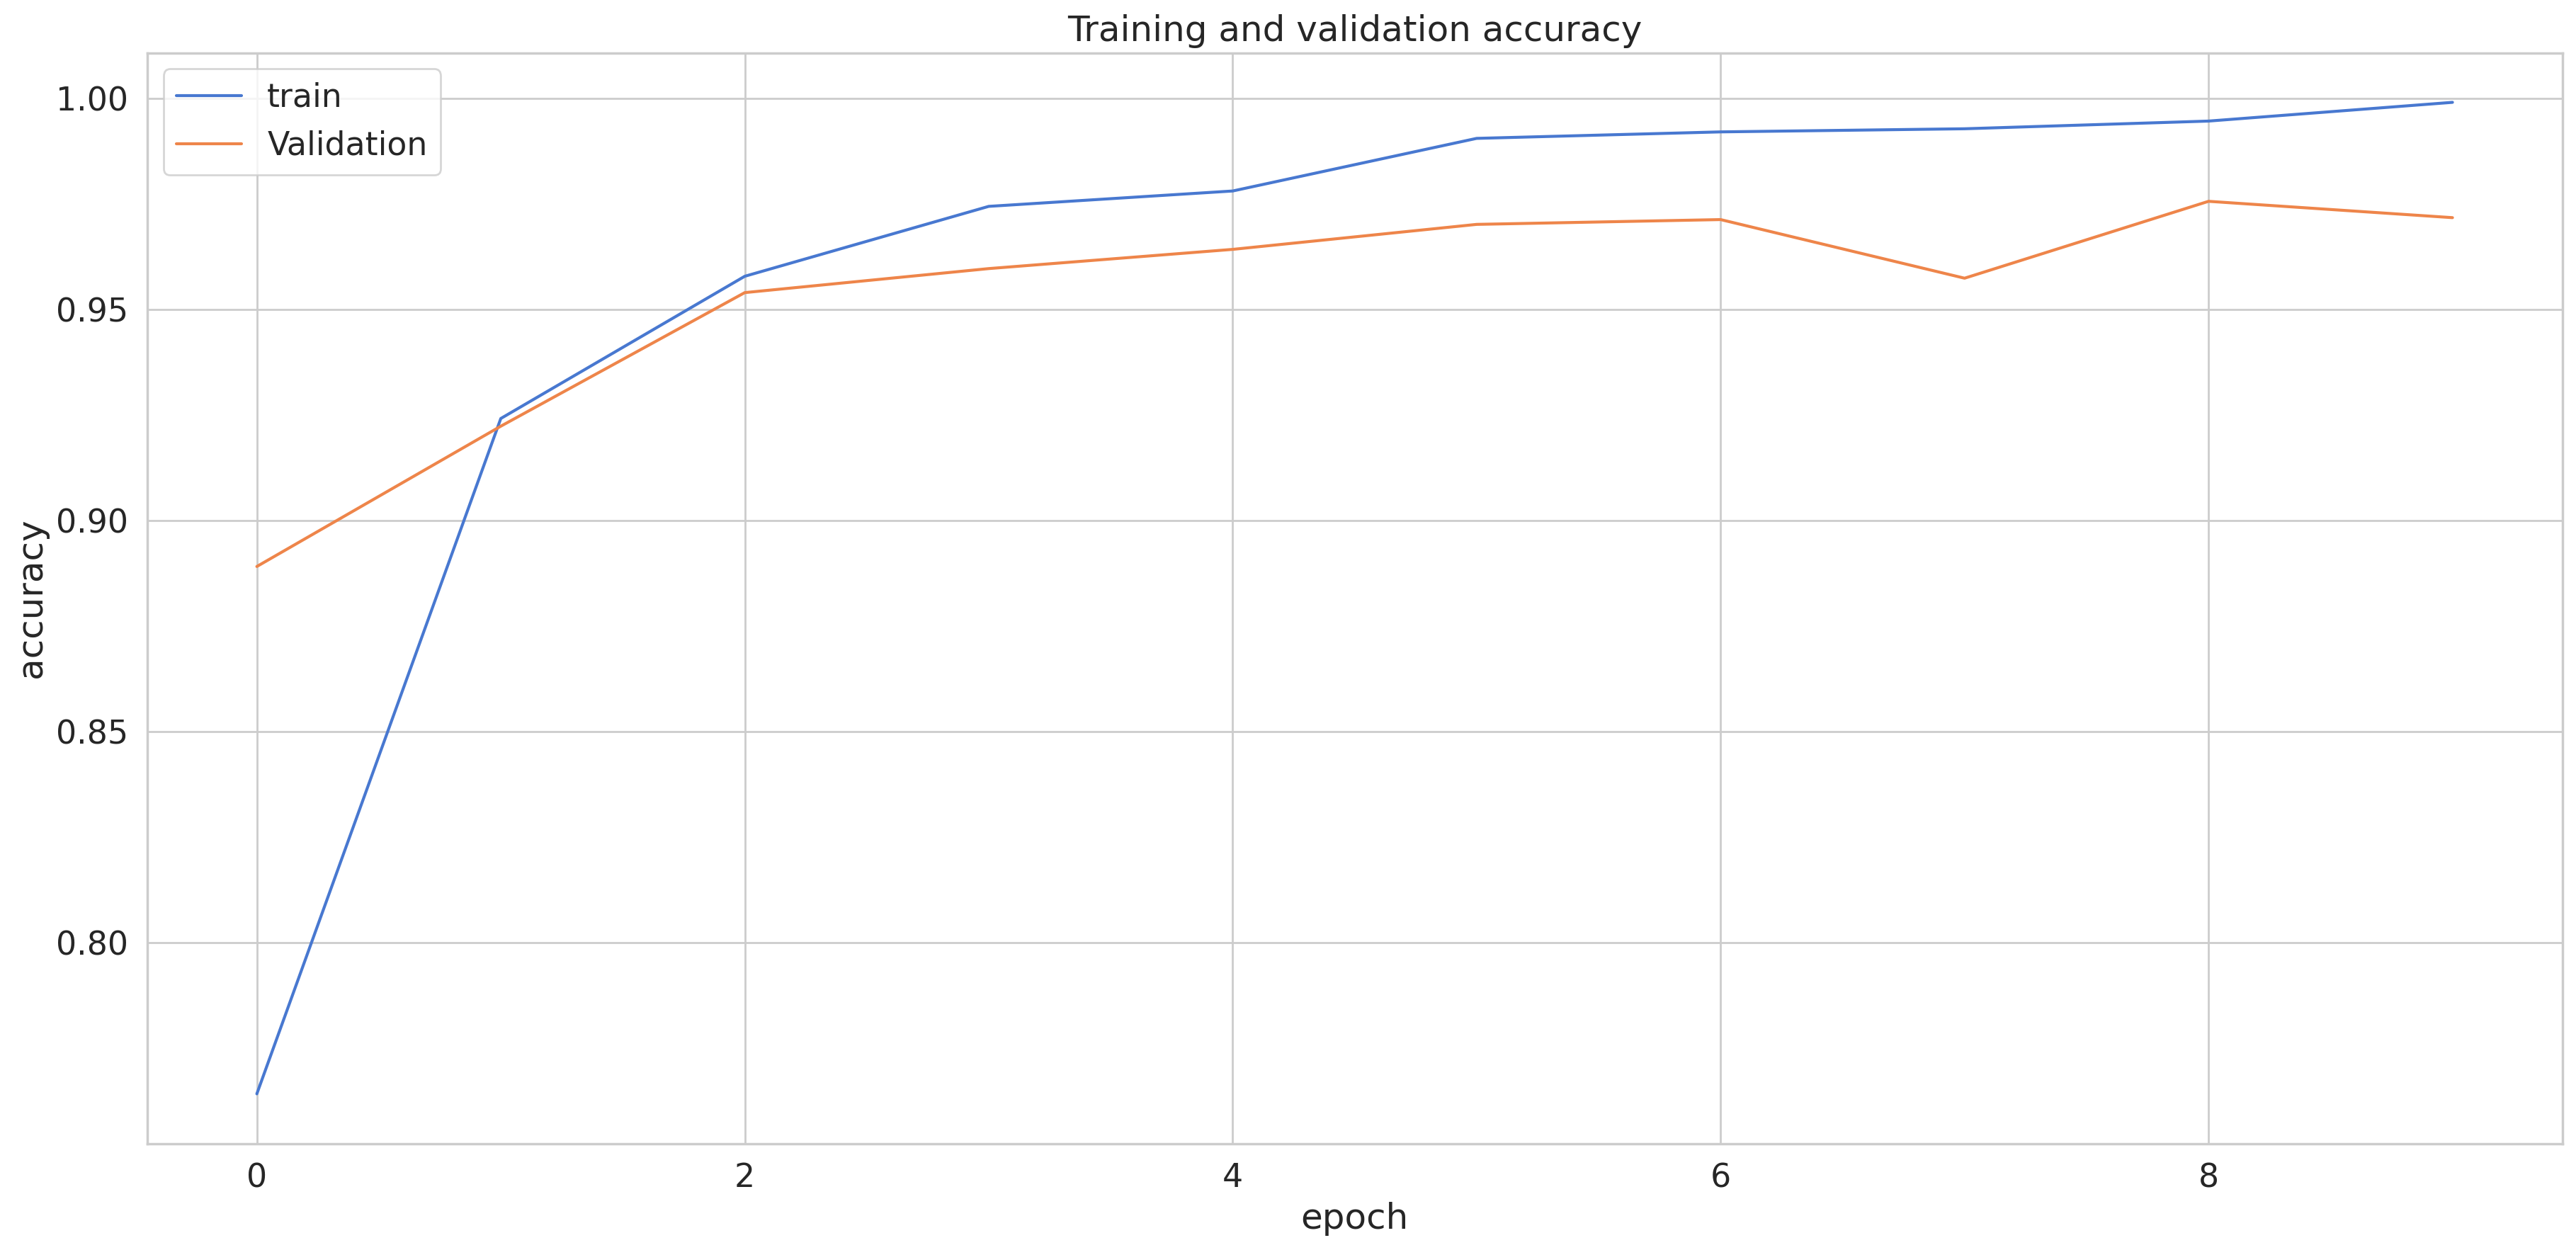

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 18ms/step
f1_score =  0.9684302871894682
0.9686760152977599
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.85      0.95      0.90       614
           3       0.98      0.80      0.88       503
           4       0.99      0.98      0.99       300
           5       0.98      0.98      0.98       241

    accuracy                           0.97      5491
   macro avg       0.96      0.95      0.95      5491
weighted avg       0.97      0.97      0.97      5491



<Axes: >

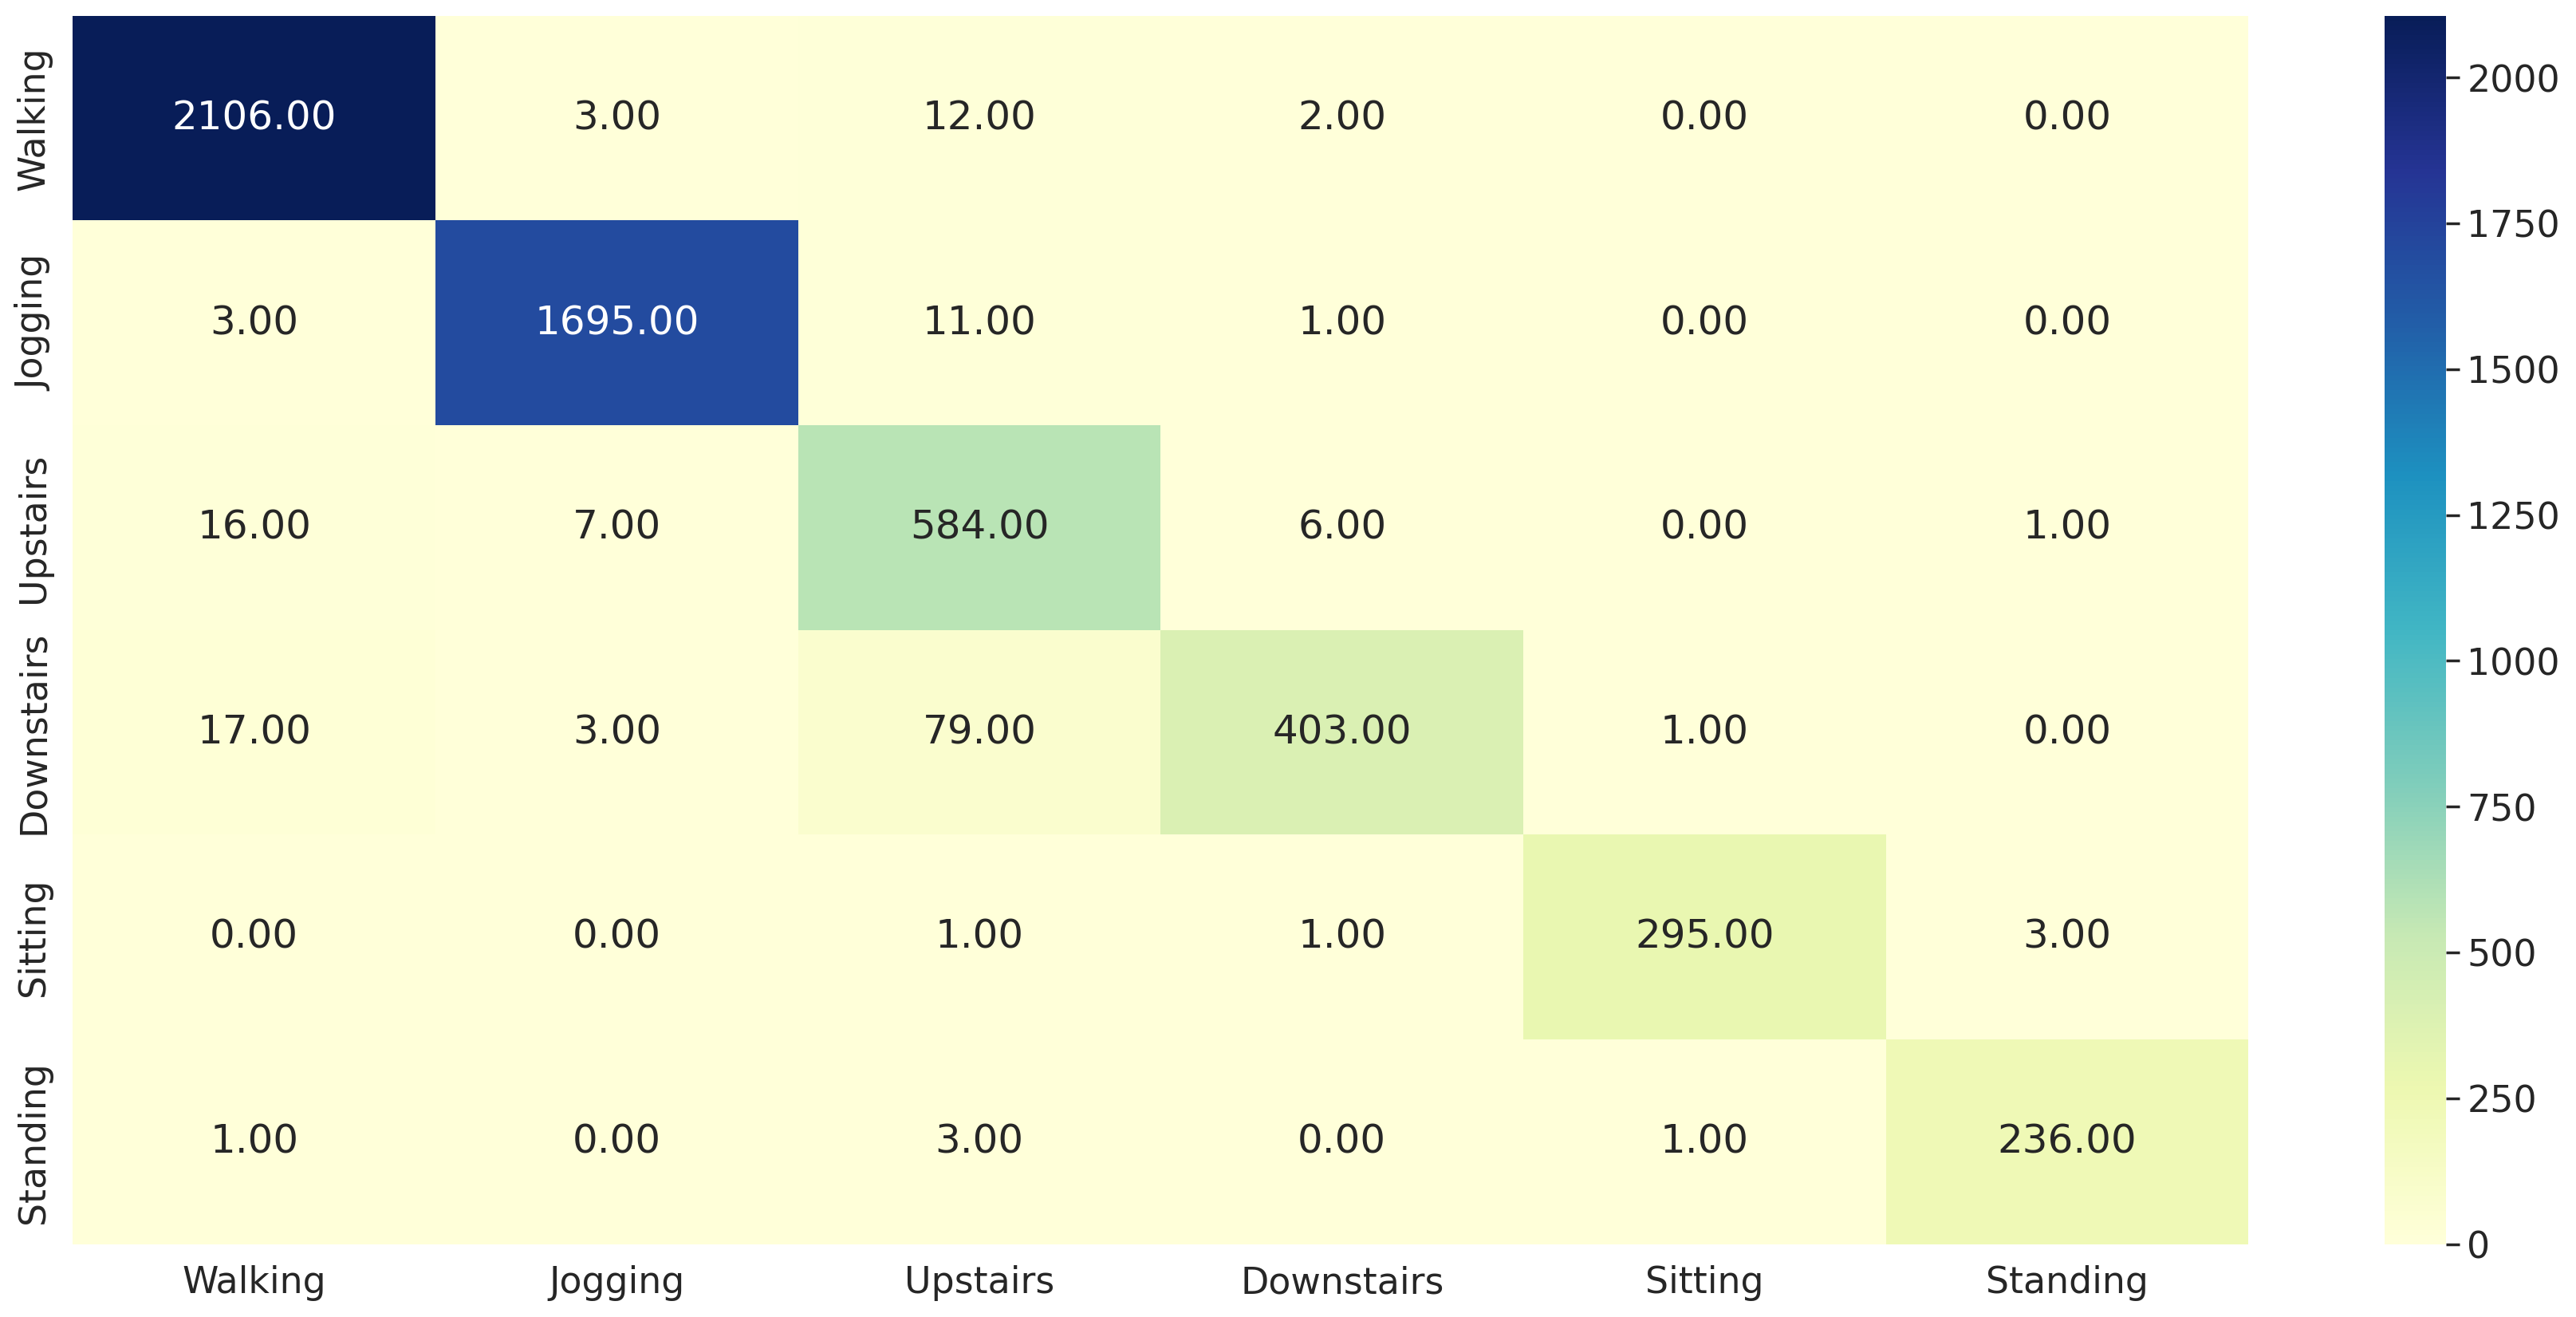

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 4

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 198, 64)           640       
                                                                 
 conv1d_13 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 conv1d_14 (Conv1D)          (None, 194, 64)           12352     
                                                                 
 conv1d_15 (Conv1D)          (None, 192, 64)           12352     
                                                                 
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               1572992   
                                                                 
 dense_13 (Dense)            (None, 6)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 33s 231ms/step - loss: 0.5273 - accuracy: 0.7976 - val_loss: 0.2701 - val_accuracy: 0.9016
Epoch 2/10
138/138 [==============================] - 32s 229ms/step - loss: 0.1845 - accuracy: 0.9355 - val_loss: 0.1537 - val_accuracy: 0.9499
Epoch 3/10
138/138 [==============================] - 32s 230ms/step - loss: 0.0973 - accuracy: 0.9685 - val_loss: 0.1188 - val_accuracy: 0.9647
Epoch 4/10
138/138 [==============================] - 32s 230ms/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.0962 - val_accuracy: 0.9699
Epoch 5/10
138/138 [==============================] - 32s 228ms/step - loss: 0.0405 - accuracy: 0.9870 - val_loss: 0.1353 - val_accuracy: 0.9542
Epoch 6/10
138/138 [==============================] - 34s 242ms/step - loss: 0.0336 - accuracy: 0.9894 - val_loss: 0.0810 - val_accuracy: 0.9724
Epoch 7/10
138/138 [==============================] - 32s 229ms/step - loss: 0.0241 - accuracy: 0.9930 - val_loss: 0.0896 - val_ac

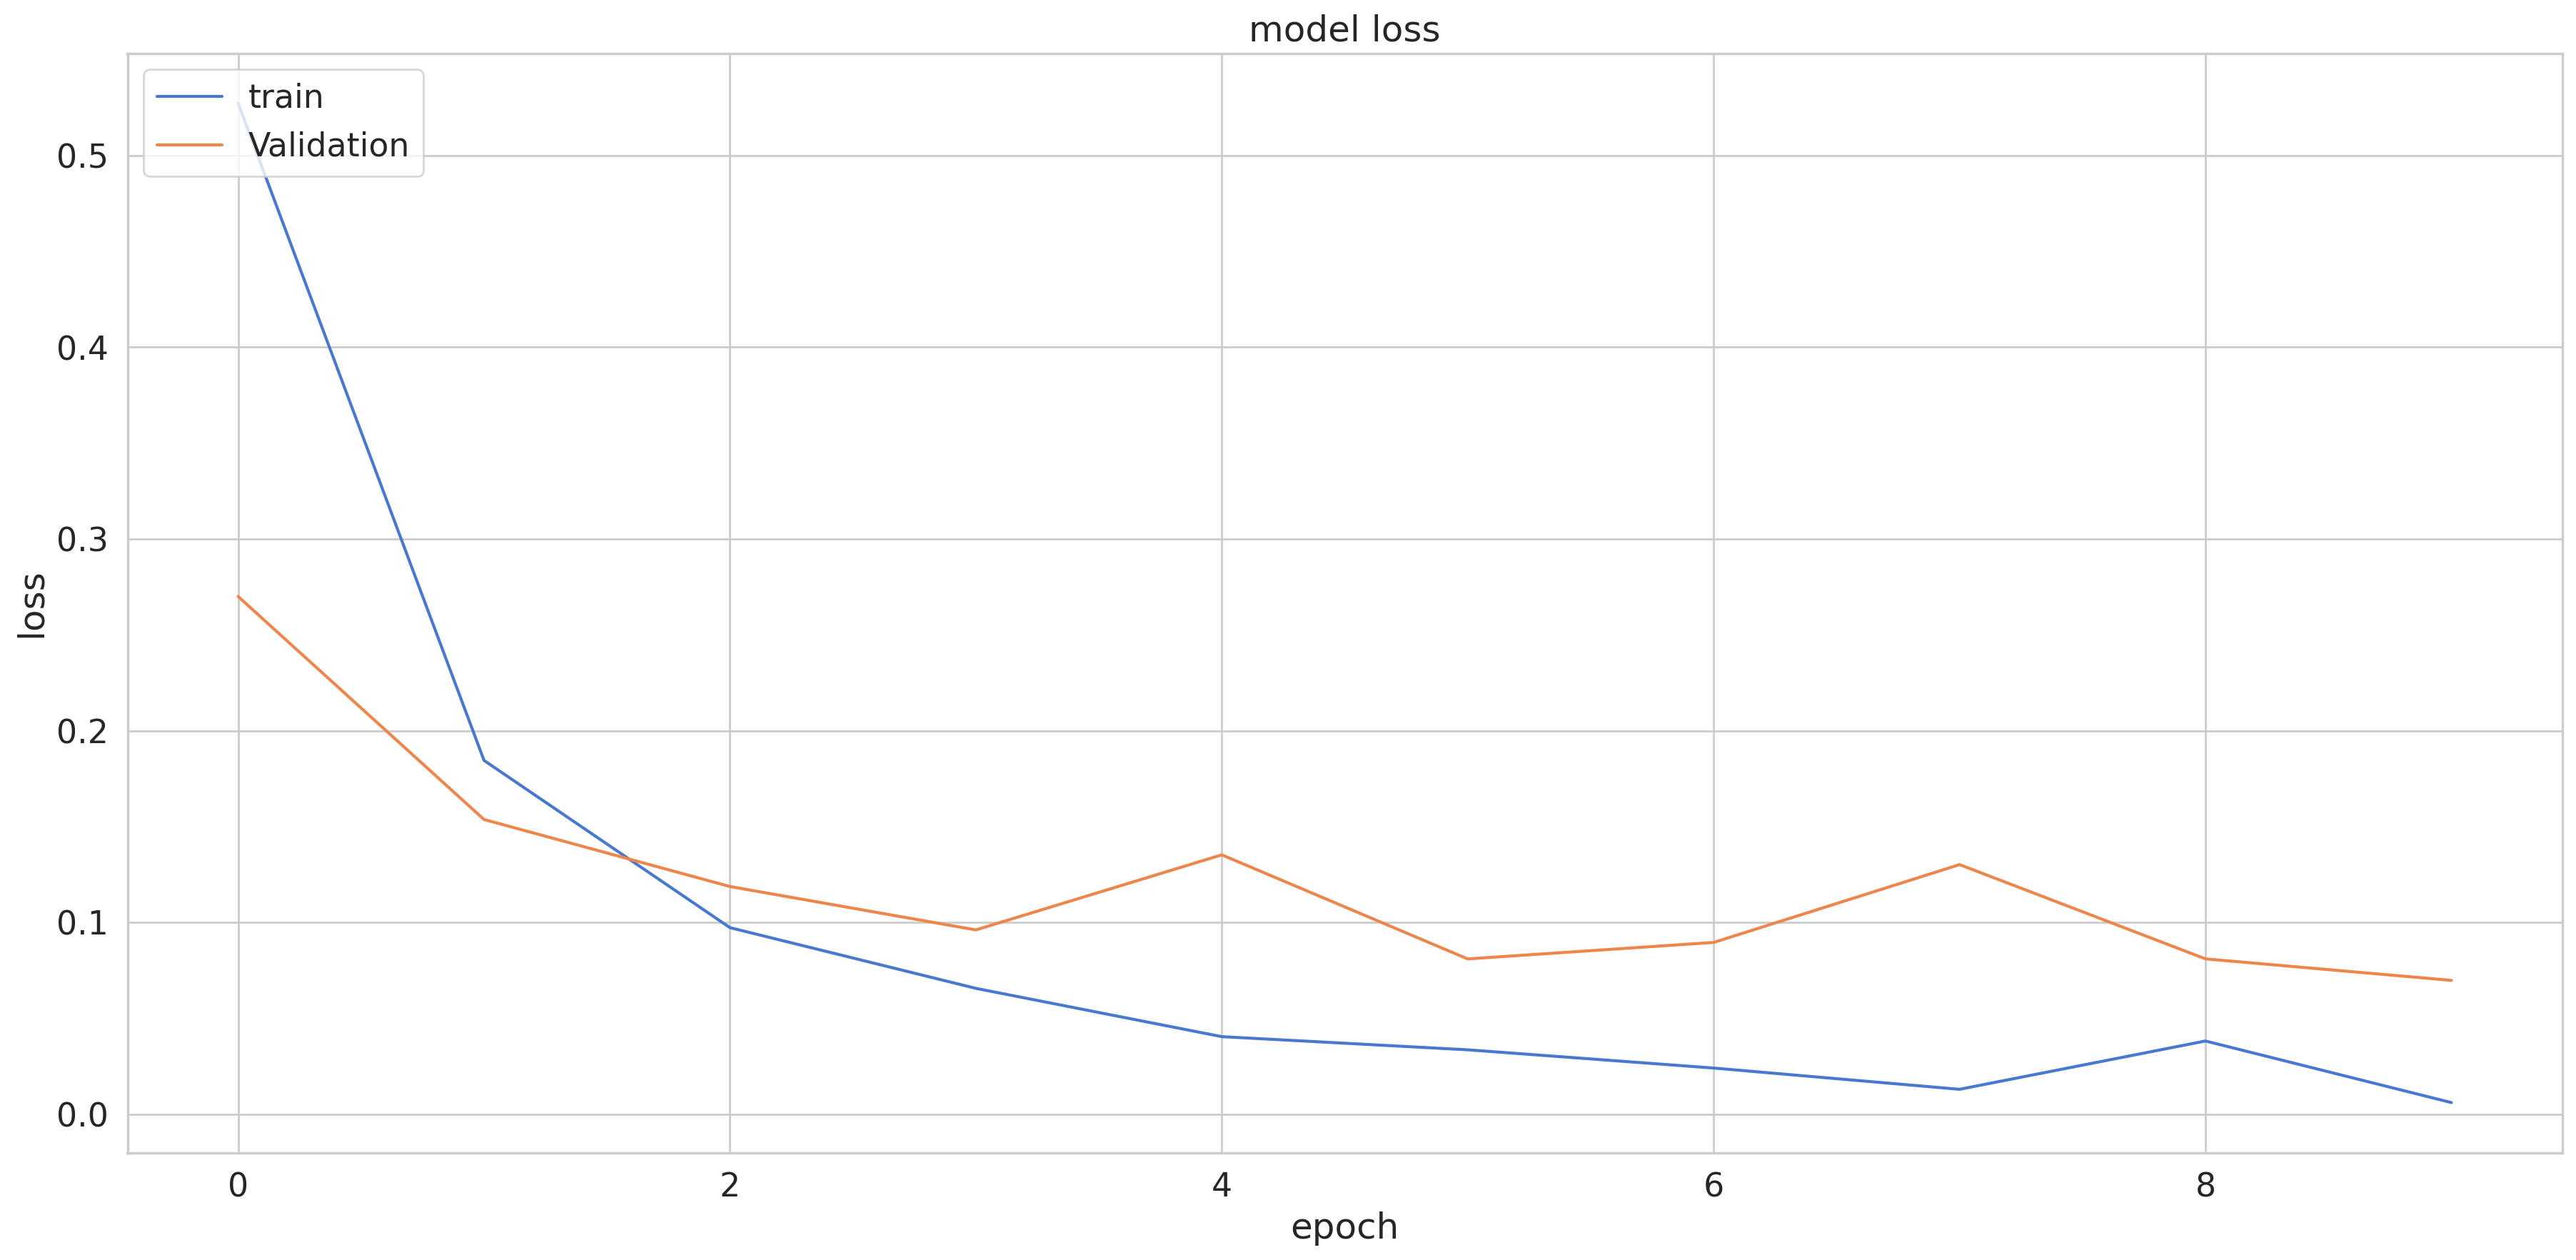

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

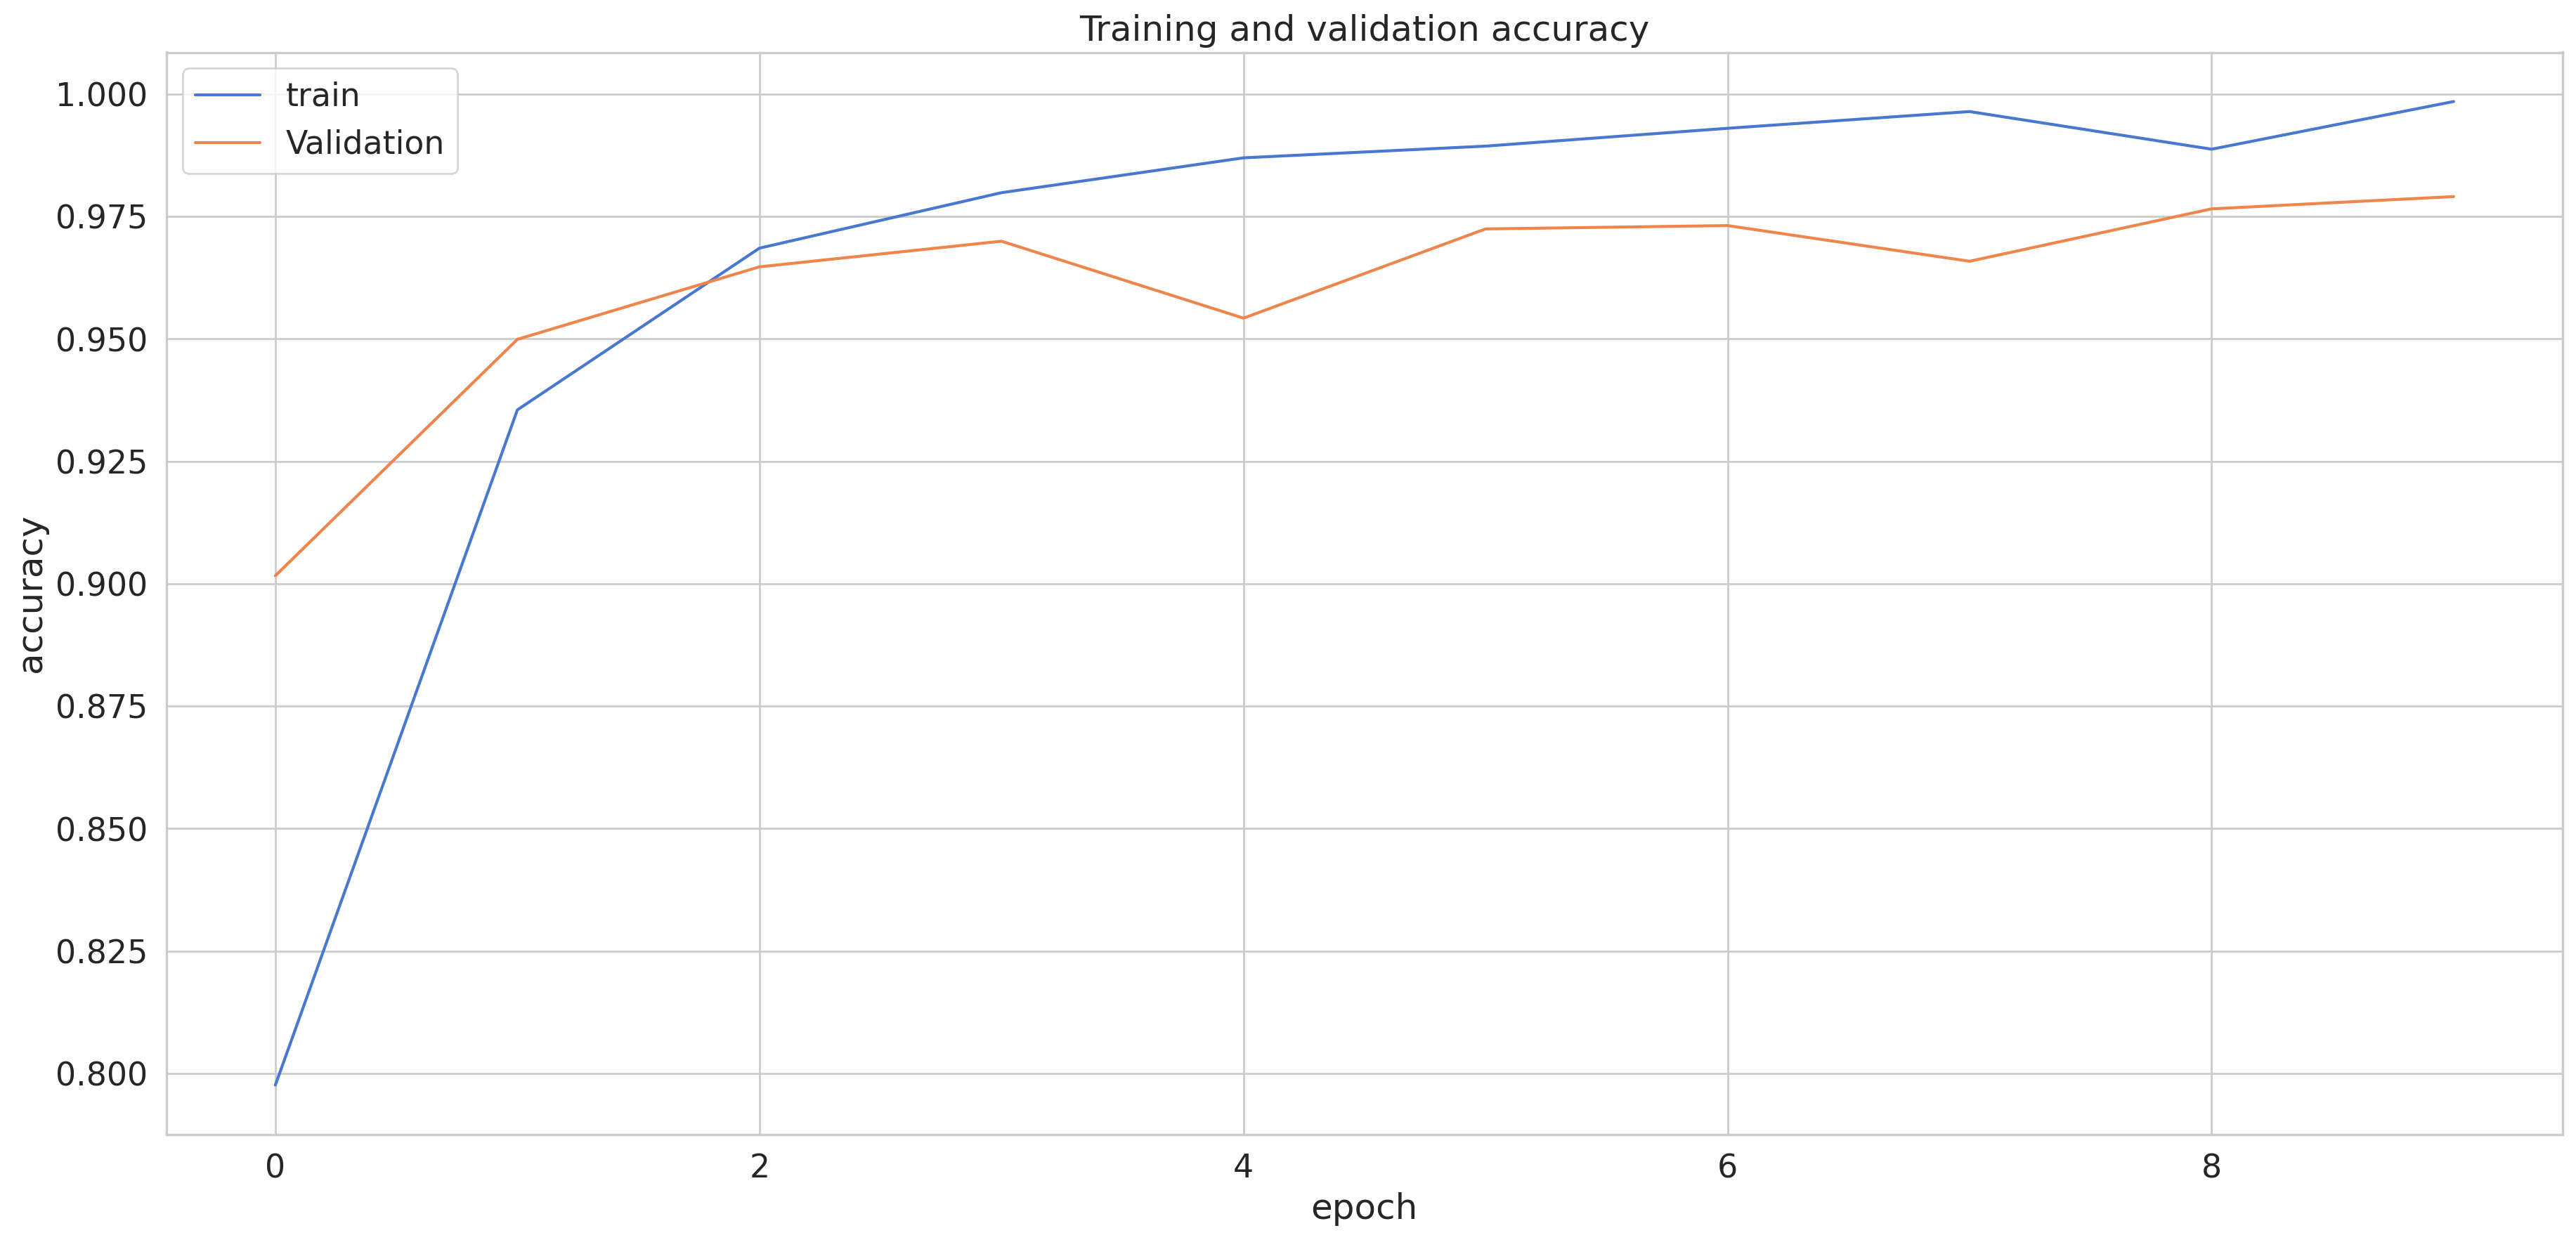

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 15ms/step
f1_score =  0.9766928276407084
0.9766891276634493
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.89      0.94      0.92       614
           3       0.95      0.89      0.92       503
           4       0.99      0.99      0.99       300
           5       0.99      0.98      0.99       241

    accuracy                           0.98      5491
   macro avg       0.97      0.96      0.97      5491
weighted avg       0.98      0.98      0.98      5491



<Axes: >

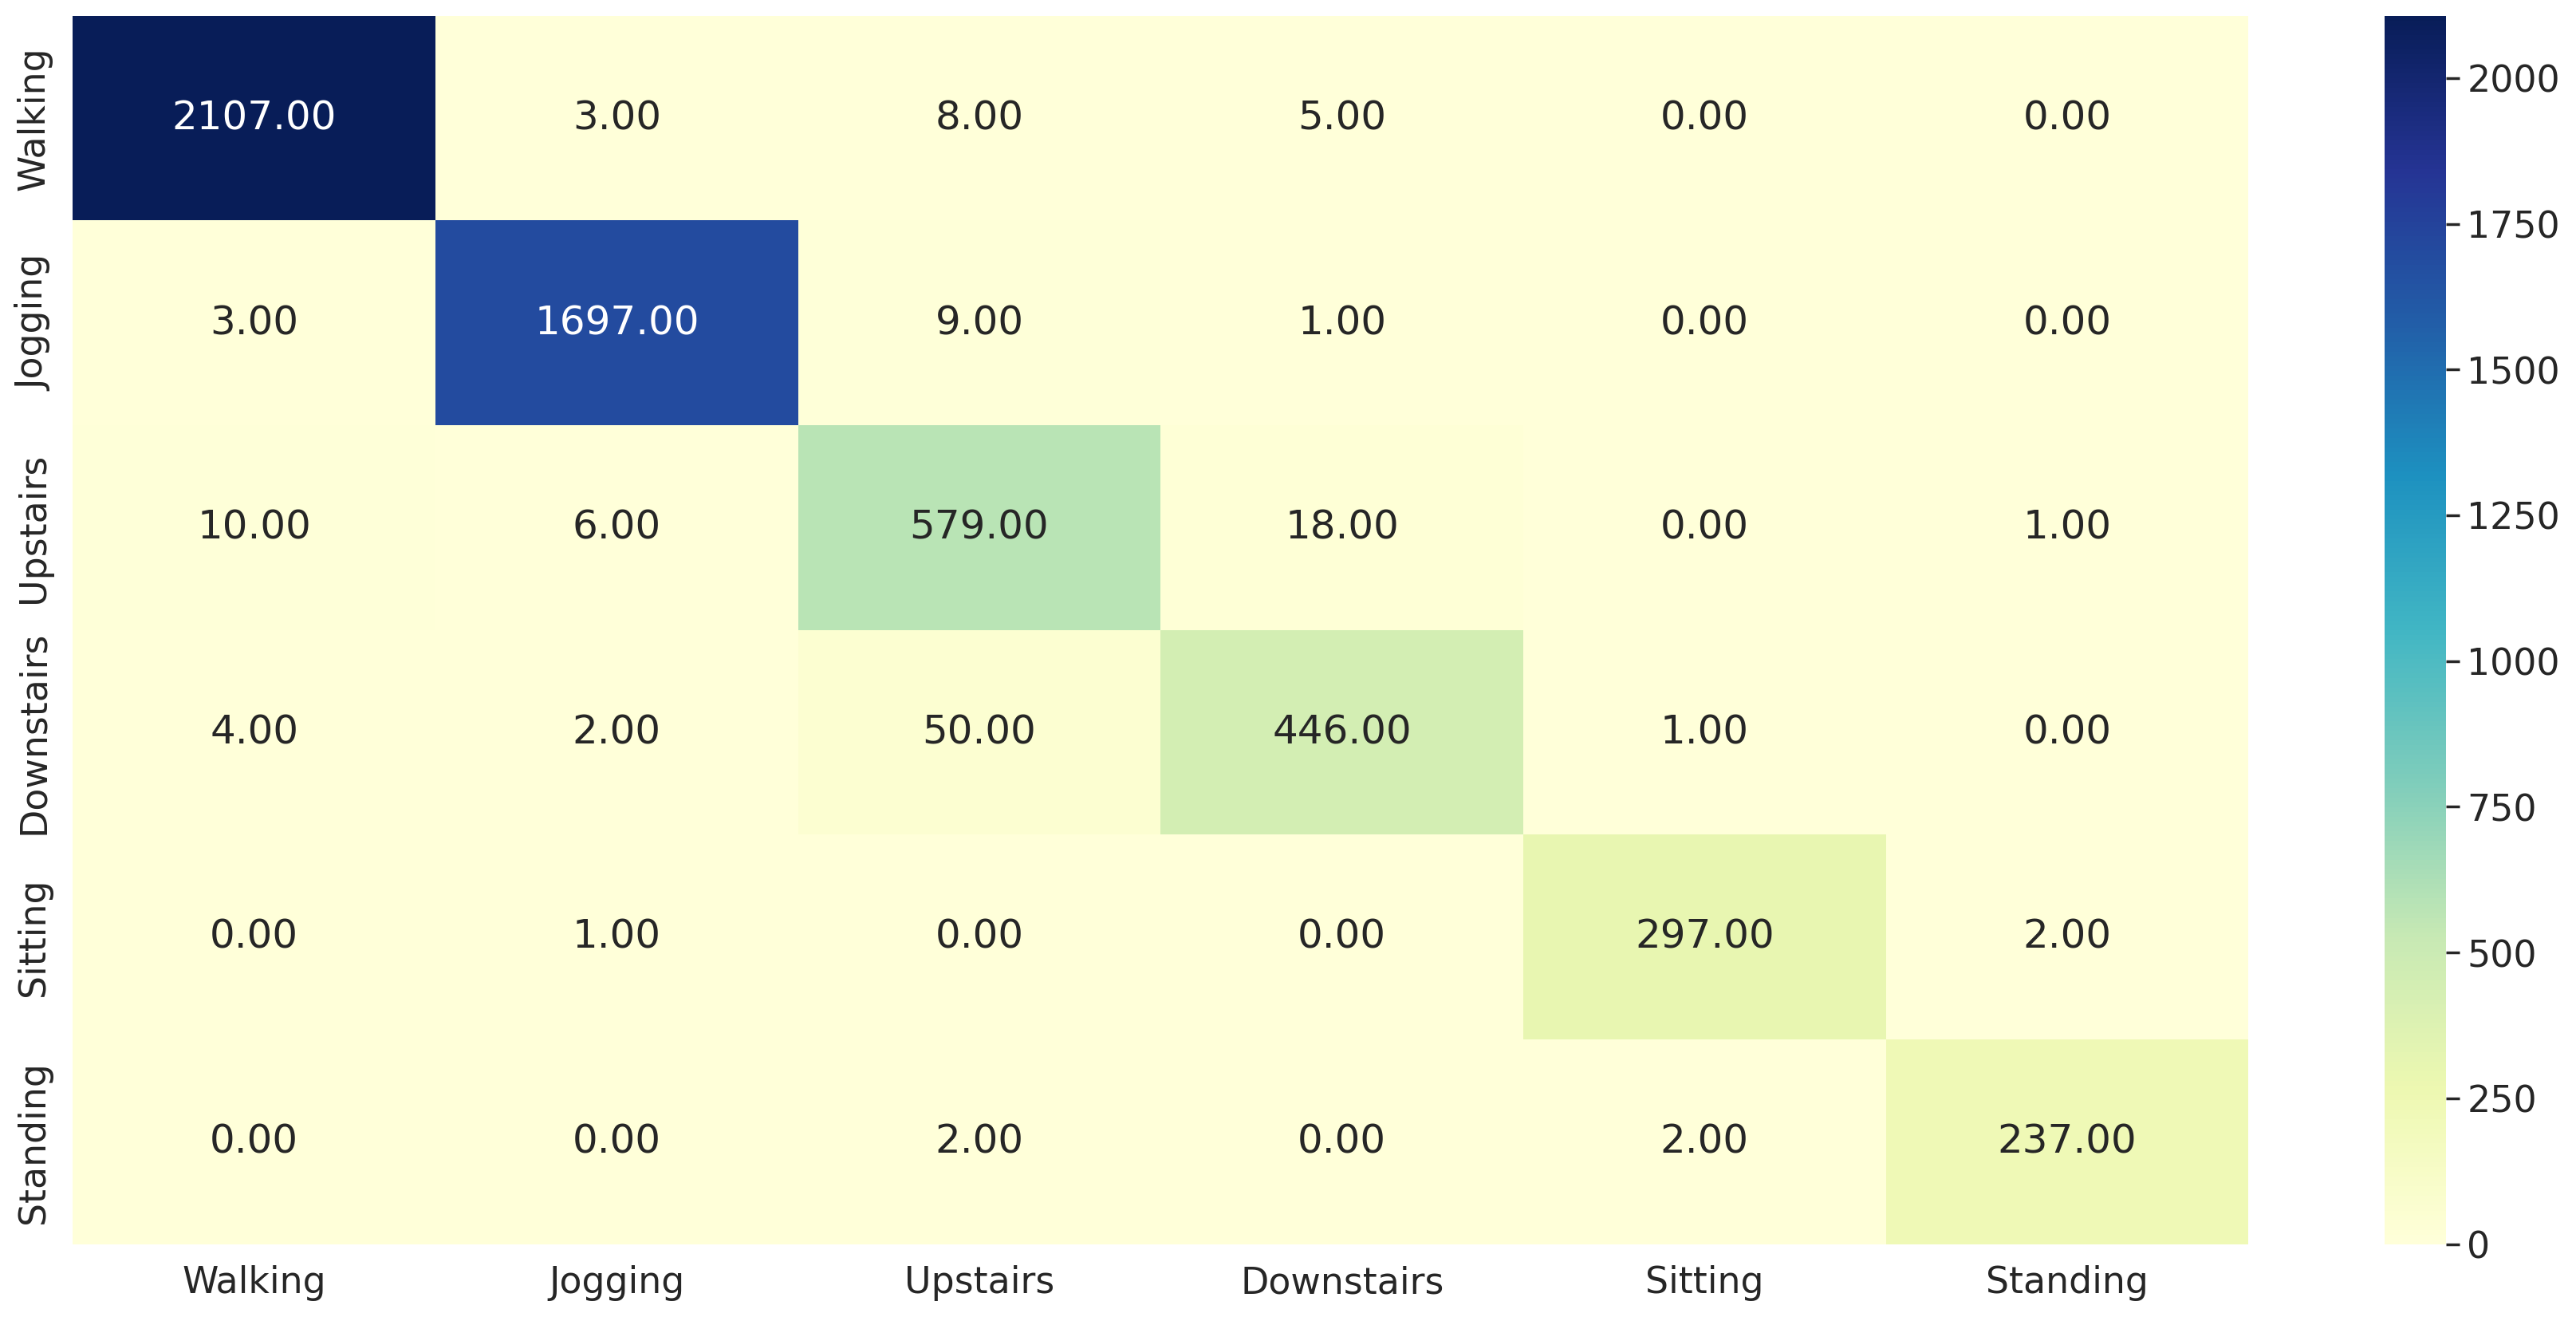

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN5

In [16]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

#model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 192, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 190, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 12160)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 25s 171ms/step - loss: 0.5506 - accuracy: 0.7834 - val_loss: 0.3381 - val_accuracy: 0.8750
Epoch 2/10
138/138 [==============================] - 21s 155ms/step - loss: 0.1979 - accuracy: 0.9265 - val_loss: 0.1595 - val_accuracy: 0.9424
Epoch 3/10
138/138 [==============================] - 22s 162ms/step - loss: 0.1038 - accuracy: 0.9642 - val_loss: 0.1581 - val_accuracy: 0.9442
Epoch 4/10
138/138 [==============================] - 21s 155ms/step - loss: 0.0681 - accuracy: 0.9775 - val_loss: 0.1339 - val_accuracy: 0.9524
Epoch 5/10
138/138 [==============================] - 22s 162ms/step - loss: 0.0460 - accuracy: 0.9841 - val_loss: 0.1371 - val_accuracy: 0.9538
Epoch 6/10
138/138 [==============================] - 21s 153ms/step - loss: 0.0366 - accuracy: 0.9867 - val_loss: 0.0929 - val_accuracy: 0.9711
Epoch 7/10
138/138 [==============================] - 23s 168ms/step - loss: 0.0407 - accuracy: 0.9867 - val_loss: 0.0857 - val_ac

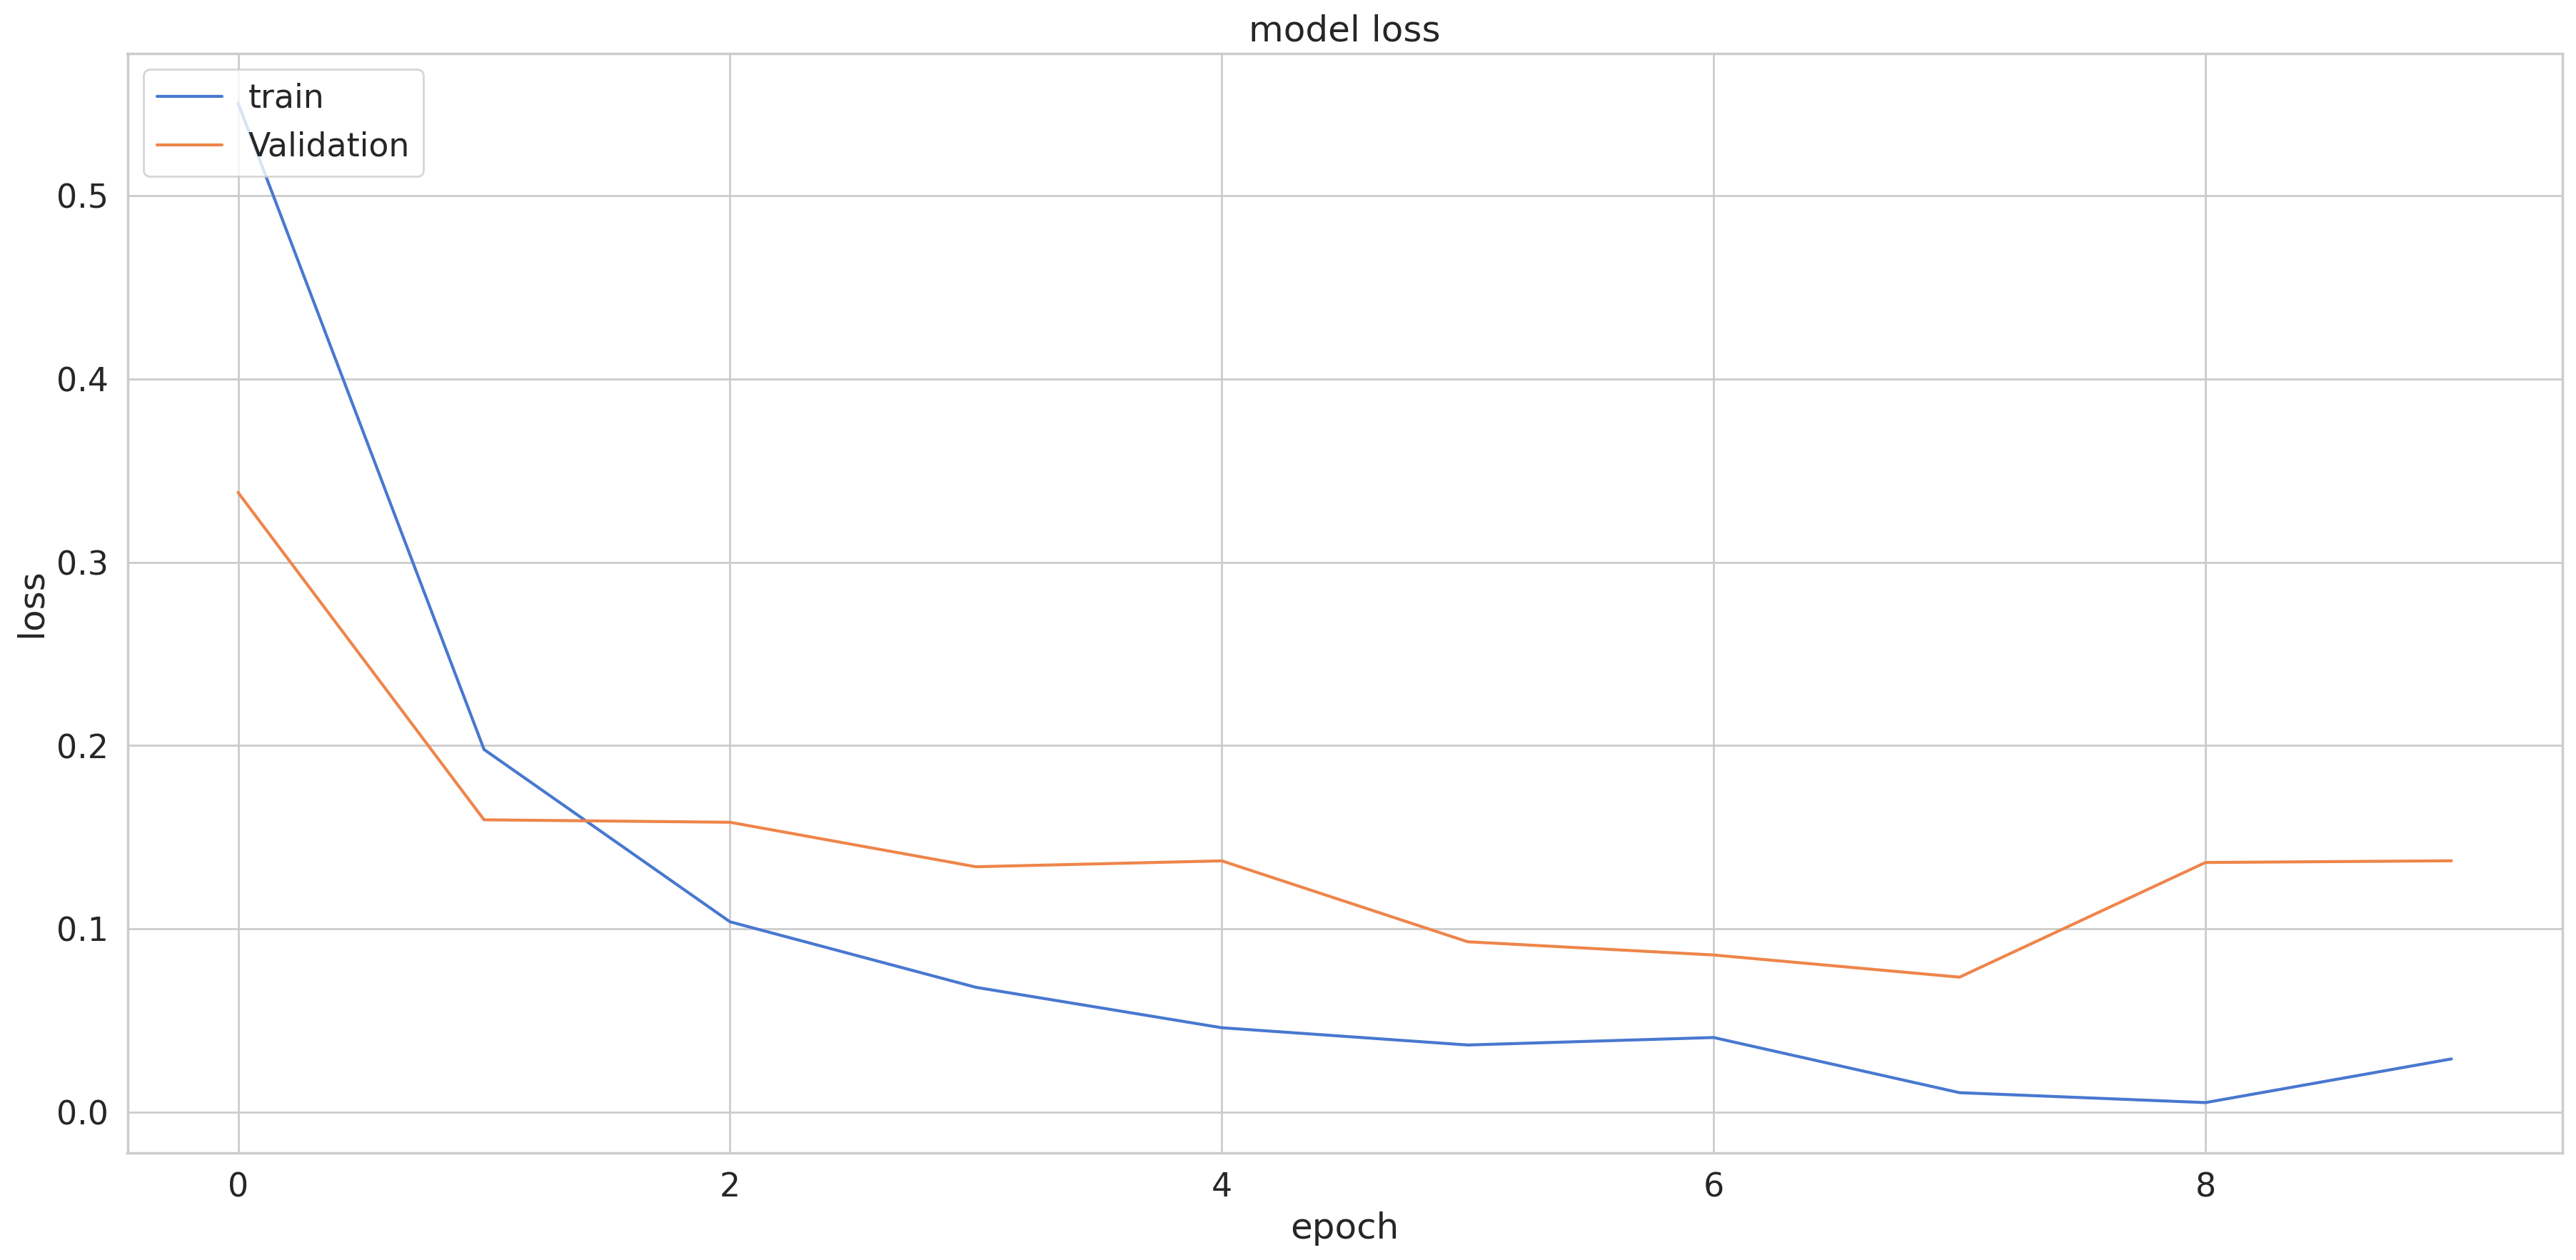

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

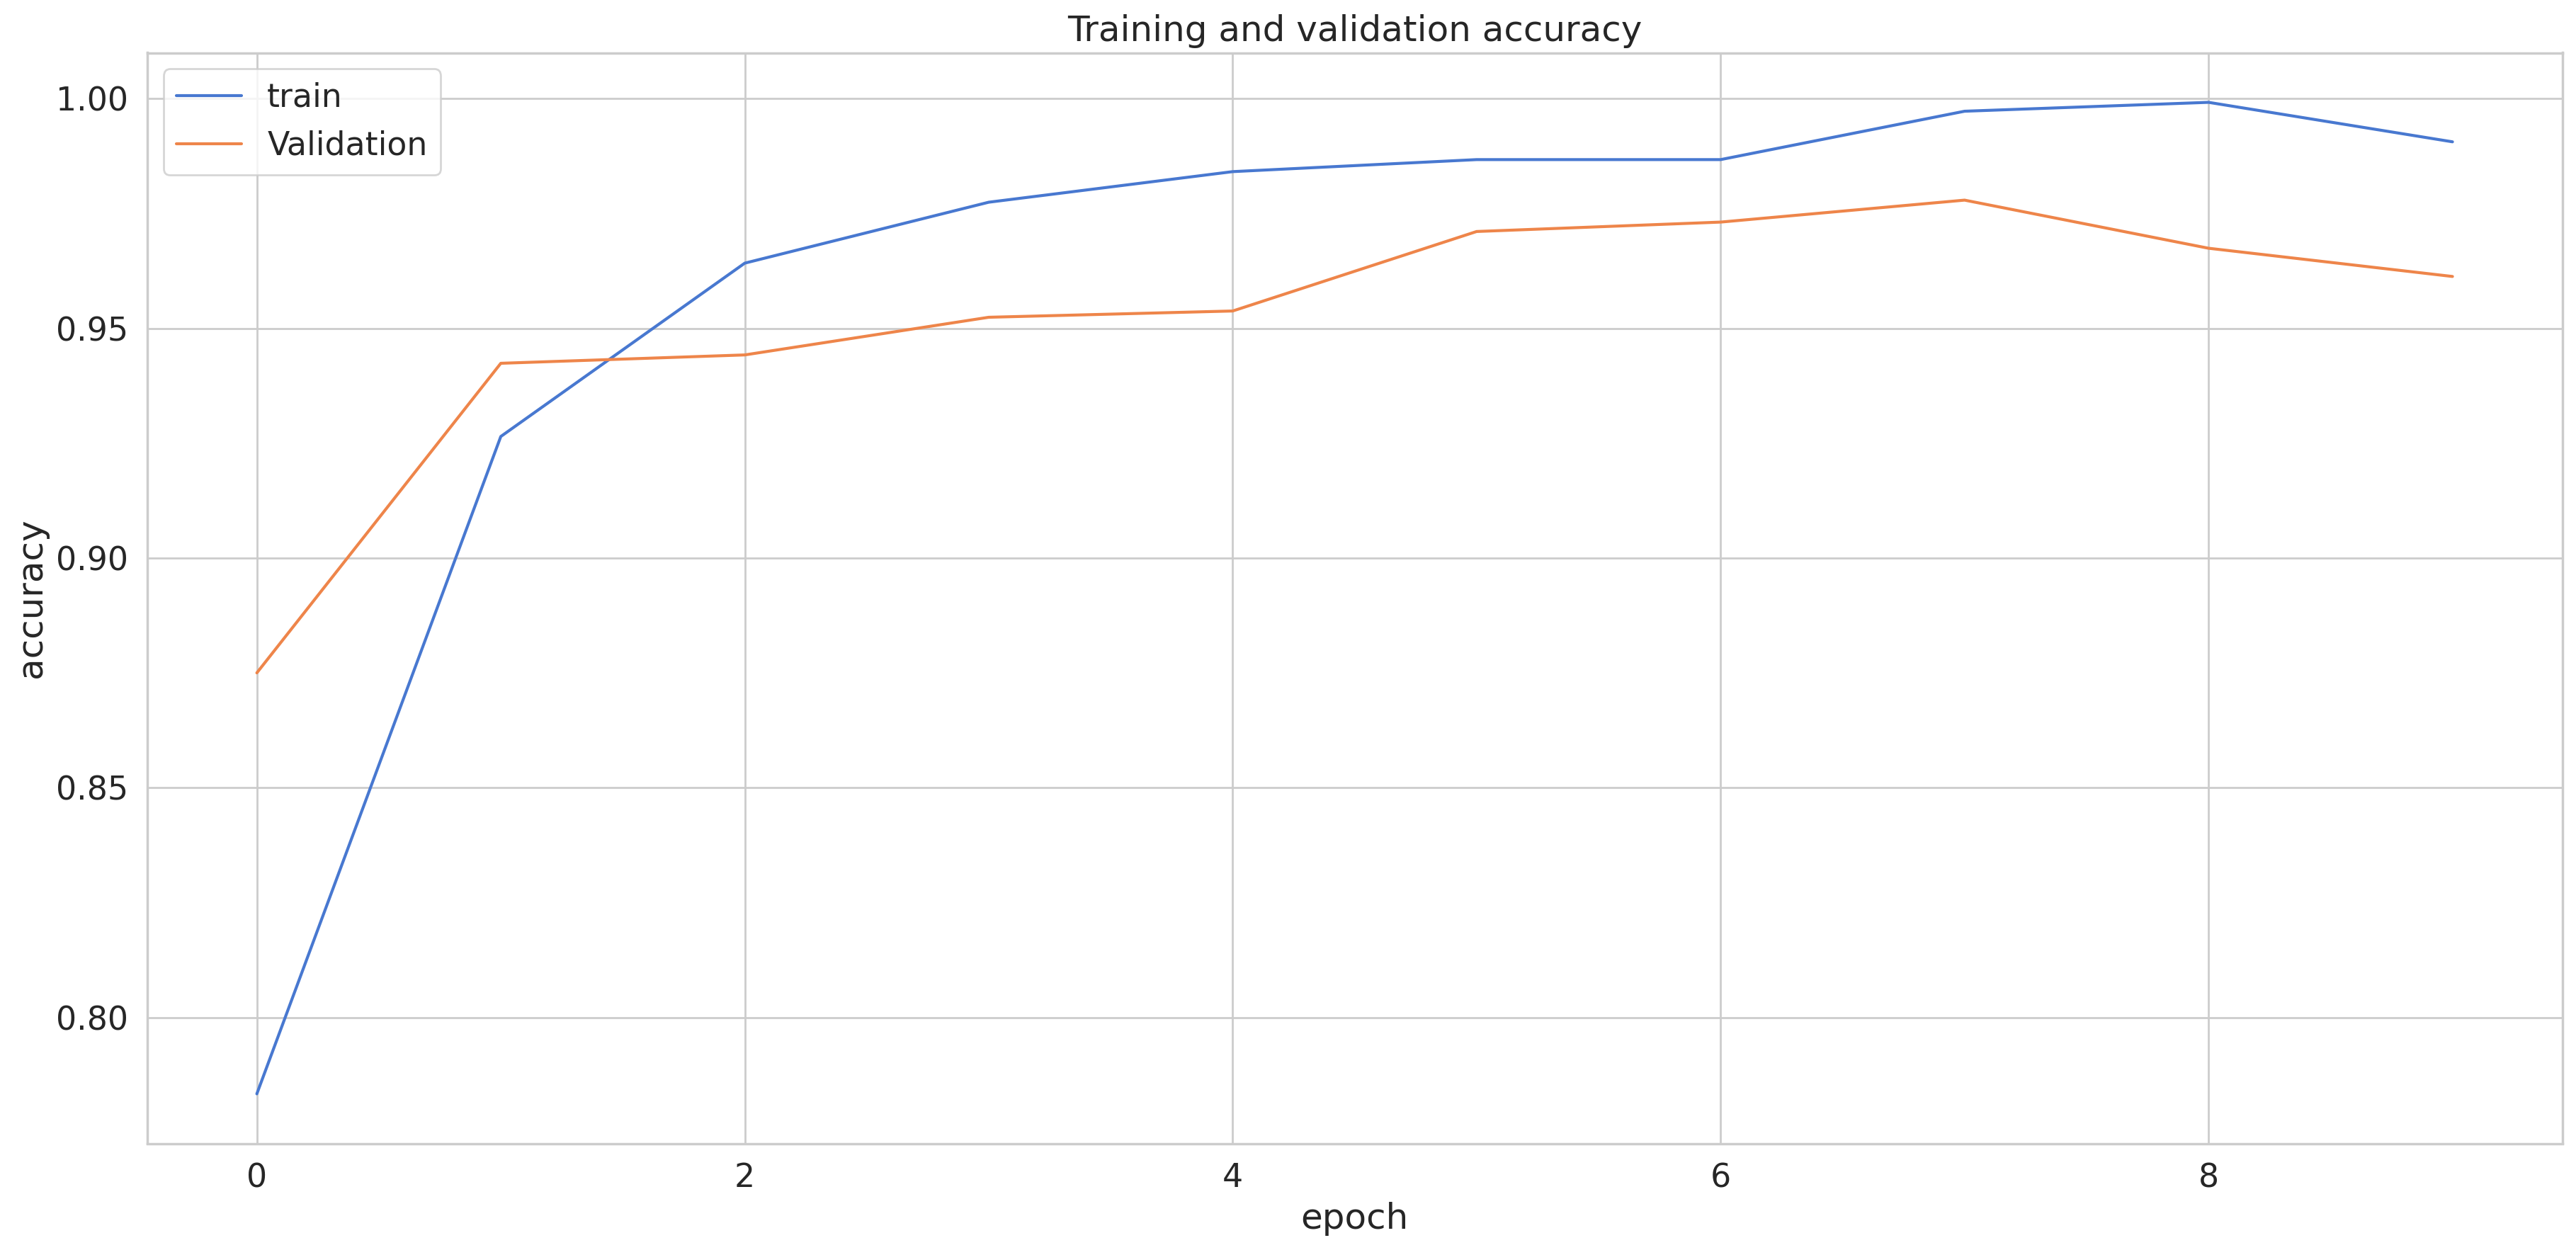

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 2s 12ms/step
f1_score =  0.966151601617686
0.9661263886359497
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2123
           1       0.96      1.00      0.98      1710
           2       0.88      0.90      0.89       614
           3       0.93      0.91      0.92       503
           4       0.98      0.98      0.98       300
           5       0.97      0.98      0.98       241

    accuracy                           0.97      5491
   macro avg       0.96      0.96      0.96      5491
weighted avg       0.97      0.97      0.97      5491



<Axes: >

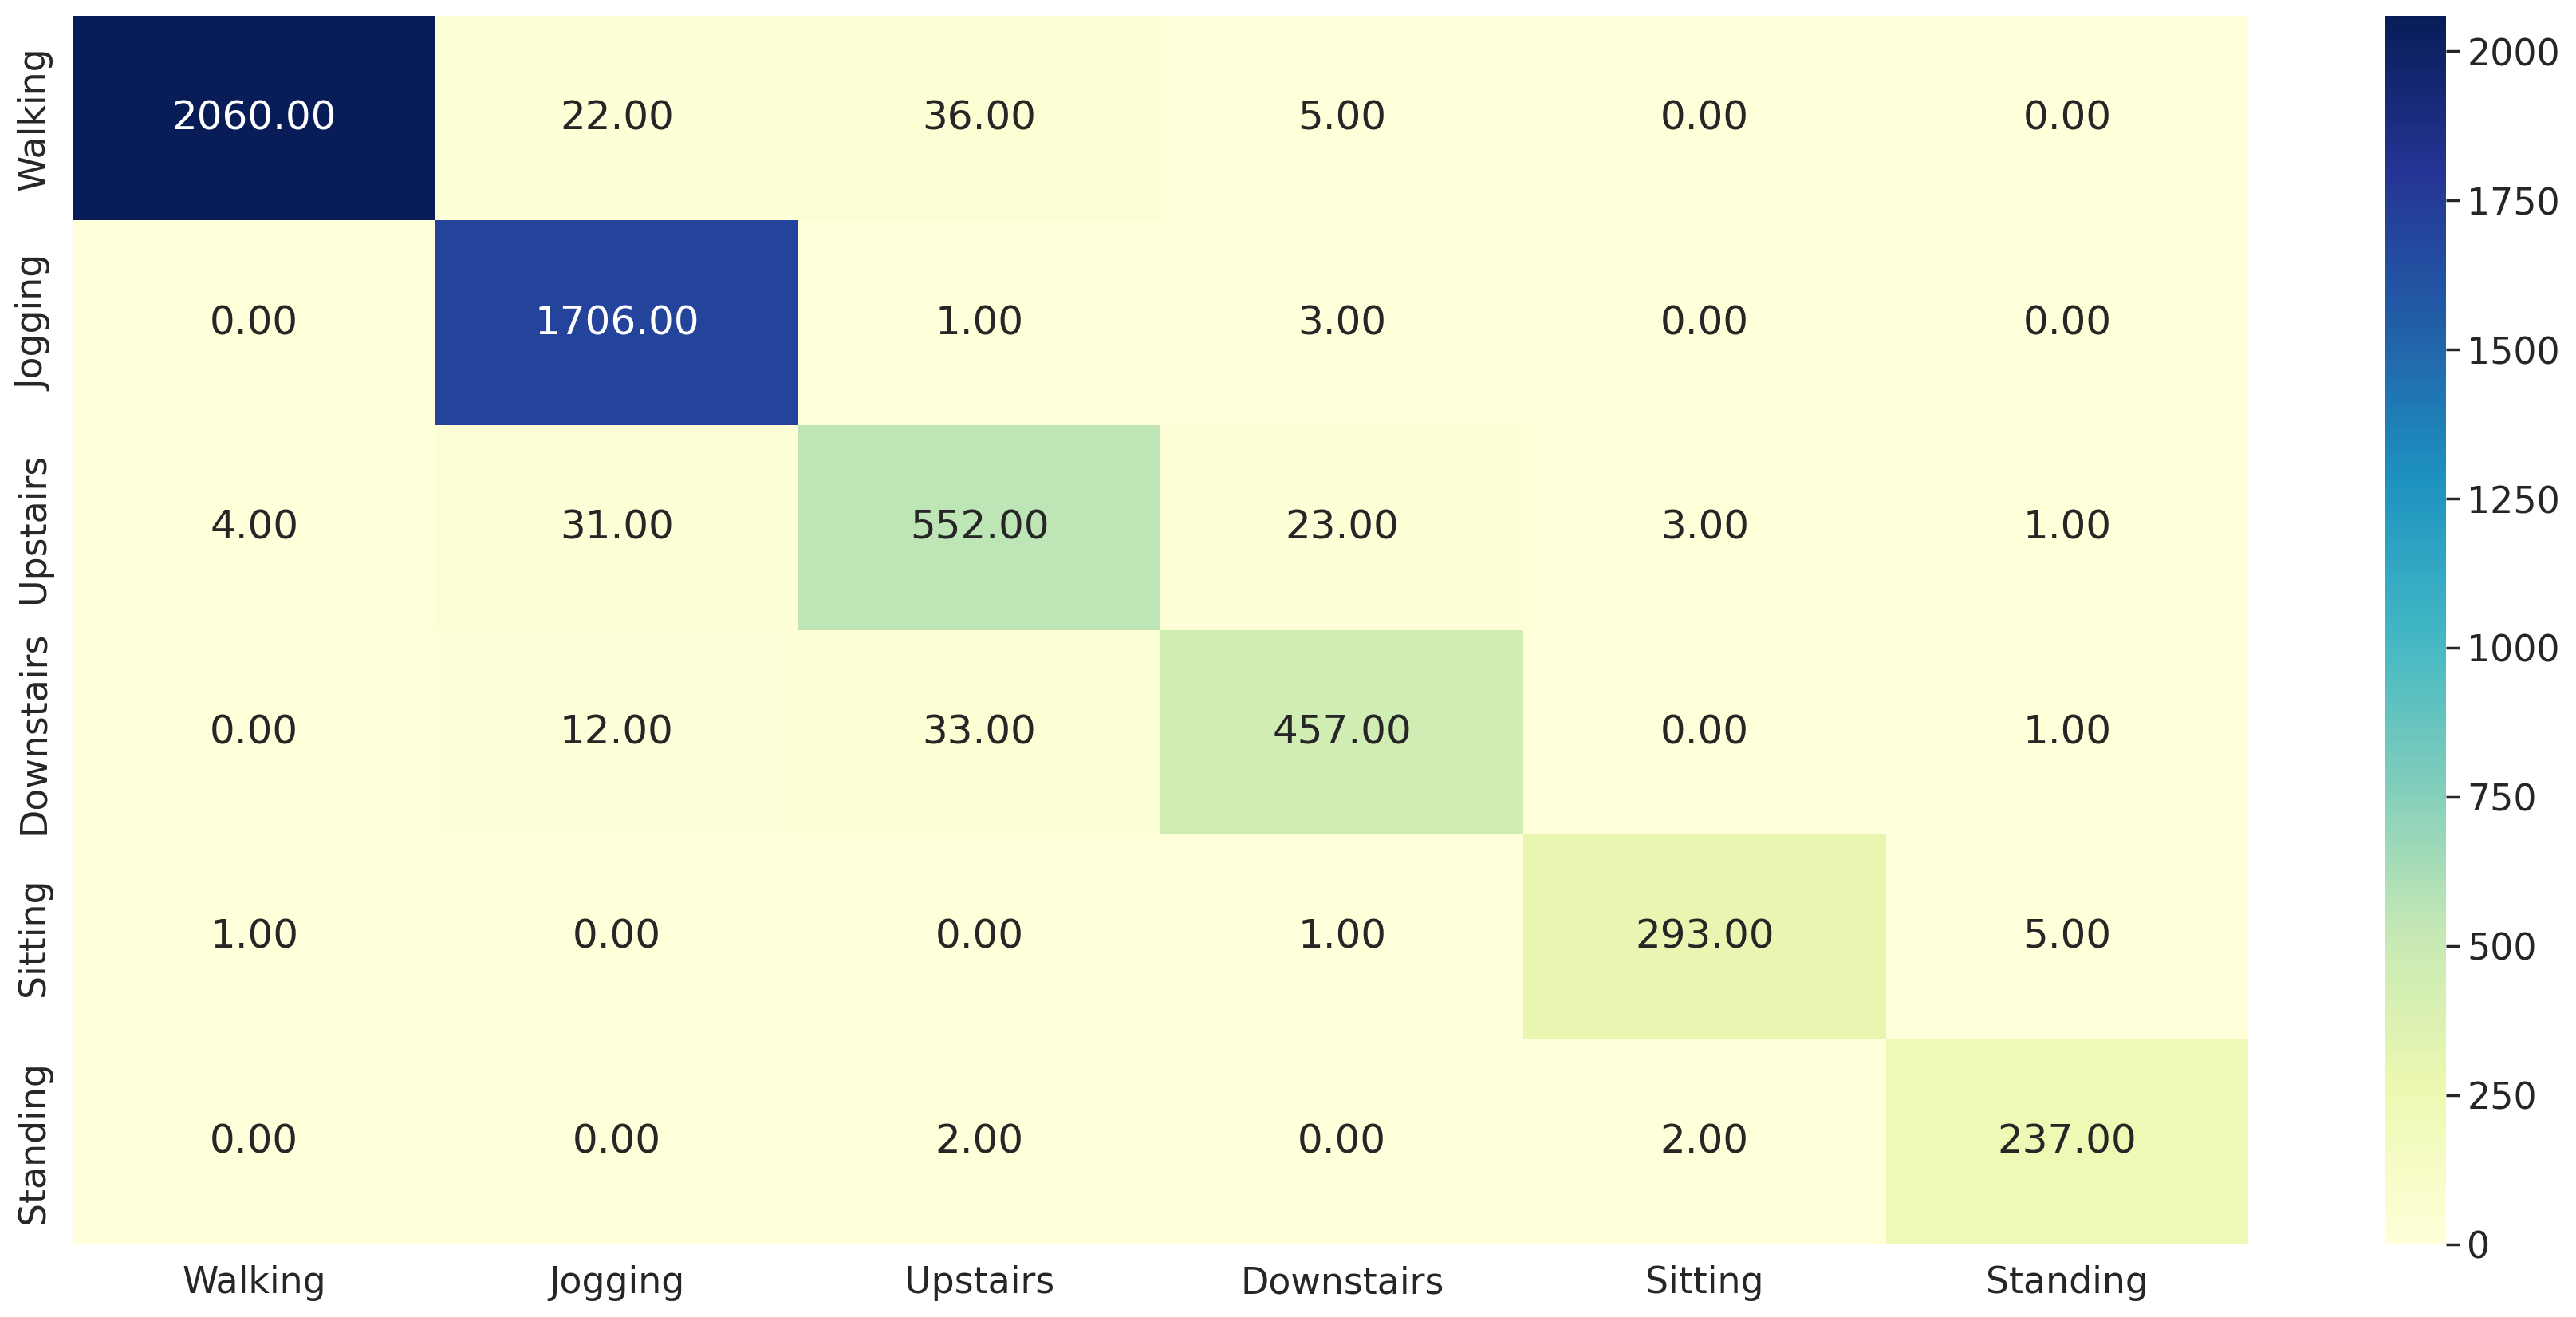

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')